In [14]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
import datetime
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import datetime
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm
from function_basic_1 import load_data
from function_basic_1 import concatenate_files
import statistics

In [15]:
######################################## biased line plot of T850 #########################################################

In [16]:
##################################### read the era5 data -- t2m, t850, z500 ##############################################################################

In [17]:
ds_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/era5/2021.h5')
ds_era5_t2m_na = ds_era.fields[656:737:4,2,260:40:-1,720:1200]
ds_era5_t850_na = ds_era.fields[656:737:4,5,260:40:-1,720:1200]
ds_era5_z500_na = ds_era.fields[656:737:4,14,260:40:-1,720:1200]
ds_era5_t2m_na_0629 = ds_era5_t2m_na[15,:,:]
ds_era5_t850_na_0629 = ds_era5_t850_na[15,:,:]
ds_era5_z500_na_0629 = ds_era5_z500_na[15,:,:]
ds_era5_t2m_box_mean = np.mean(ds_era5_t2m_na[:,61:141,194:274], axis=(1, 2))
ds_era5_t850_box_mean = np.mean(ds_era5_t850_na[:,61:141,194:274], axis=(1, 2))
ds_era5_z500_box_mean = np.mean(ds_era5_z500_na[:,61:141,194:274], axis=(1, 2))

ds_era5_t2m_box_0629_mean = ds_era5_t2m_box_mean[15]
ds_era5_t850_box_0629_mean = ds_era5_t850_box_mean[15]
ds_era5_z500_box_0629_mean = ds_era5_z500_box_mean[15]

In [3]:
%store -r ds_era5_t2m_na_0629 
%store -r ds_era5_t850_na_0629 
%store -r ds_era5_z500_na_0629 
%store -r ds_era5_t2m_box_mean 
%store -r ds_era5_t850_box_mean
%store -r ds_era5_z500_box_mean 

In [4]:
def calculate_batch_difference(v1, v2, batch_size):
    """
    Calculate the point-wise difference between two arrays (v2 - v1) in batches.

    Parameters:
    - v1: The first input array.
    - v2: The second input array.
    - batch_size: The desired batch size for processing.

    Returns:
    - An array containing the point-wise differences between v2 and v1.
    """
    # Get the shape of the input arrays
    rows, cols = v1.shape
    
    # Initialize the difference array
    difference = np.empty((rows, cols))

    for i in range(0, rows, batch_size):
        for j in range(0, cols, batch_size):
            batch_variable1 = v1[i:i + batch_size, j:j + batch_size]
            batch_variable2 = v2[i:i + batch_size, j:j + batch_size]
            
            # Calculate the difference point by point for the current batch
            batch_difference = batch_variable2 - batch_variable1

            # Update the difference array with the current batch_difference
            difference[i:i + batch_size, j:j + batch_size] = batch_difference

    return difference

In [ ]:
############################################## load the ECMWF data---control forecast ############################################################

In [5]:
def read_and_choose_variable_ec(directory, filename_pattern, variable_name, level ):
    # Read data and choose the variable
    files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
    variable_data_list = []

    for file in files:
        file_path = os.path.join(directory, file)
        ds = xr.open_dataset(file_path)
        if level is not None:
            variable_data = ds[variable_name][:, level, :, :]
        else:
            variable_data = ds[variable_name]

        variable_data_list.append(variable_data)

    ds_variable_na = xr.DataArray(variable_data_list)

    return ds_variable_na

In [6]:
def process_target_forecast(ds, start_index, step_size, num_iterations):
    'choose the certain date and lead time and get the target forecast'
    ds_target_forecast = []
    for i in range(num_iterations):
        ec_value = ds[(i + 1) * step_size, start_index - i * step_size * 4, :, :]
        ds_target_forecast.append(ec_value)

    ds_target_forecast = xr.DataArray(ds_target_forecast)

    return ds_target_forecast
'''#usage example
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_t2m_box
ds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'''

'#usage example\nstart_index = 56\nstep_size = 1\nnum_iterations = 15\nds=ds_ec_t2m_box\nds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'

In [9]:
#read data and choose variable----t2m
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_sfc\.nc'
variable_name = 't2m'
level = None # No level for surface variables
ds_ec_t2m_na = read_and_choose_variable_ec(directory, filename_pattern, variable_name, level)
#ds_ec_z500_na_0629
#choose the box
ds_ec_t2m_box=ds_ec_t2m_na[:,:,79:159,194:274]

In [10]:
#choose the target day in the whole NA area
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_t2m_na
ds_ec_t2m_na_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)

In [11]:
ds_ec_t2m_box_0629 = ds_ec_t2m_na_0629[:,79:159,194:274]

In [12]:
#calculate the mean of box
ds_ec_t2m_box_0629_mean = np.mean(ds_ec_t2m_box_0629, axis=(1, 2))

In [ ]:
########################################## load the ECMWF data ----- predictability froecast ---t2m########################################################

In [13]:
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210615_00_sfc.nc') 
variable_data_ec_1 = ds_ec_1['t2m'][56,:,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210616_00_sfc.nc') 
variable_data_ec_2 = ds_ec_2['t2m'][52,:,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210617_00_sfc.nc') 
variable_data_ec_3 = ds_ec_3['t2m'][48,:,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210618_00_sfc.nc') 
variable_data_ec_4 = ds_ec_4['t2m'][44,:,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210619_00_sfc.nc') 
variable_data_ec_5 = ds_ec_5['t2m'][40,:,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210620_00_sfc.nc') 
variable_data_ec_6 = ds_ec_6['t2m'][36,:,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210621_00_sfc.nc') 
variable_data_ec_7 = ds_ec_7['t2m'][32,:,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210622_00_sfc.nc') 
variable_data_ec_8 = ds_ec_8['t2m'][28,:,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210623_00_sfc.nc') 
variable_data_ec_9 = ds_ec_9['t2m'][24,:,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210624_00_sfc.nc') 
variable_data_ec_10 = ds_ec_10['t2m'][20,:,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210625_00_sfc.nc') 
variable_data_ec_11 = ds_ec_11['t2m'][16,:,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210626_00_sfc.nc') 
variable_data_ec_12 = ds_ec_12['t2m'][12,:,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210627_00_sfc.nc') 
variable_data_ec_13 = ds_ec_13['t2m'][8,:,:,:]

ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210628_00_sfc.nc') 
variable_data_ec_14 = ds_ec_14['t2m'][4,:,:,:]

ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210629_00_sfc.nc') 
variable_data_ec_15 = ds_ec_15['t2m'][0,:,:,:]

In [14]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [13]})

In [15]:
ds_ec_t2m_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [16]:
ds_ec_t2m_na_0629_ens = xr.DataArray(ds_ec_t2m_na_0629_ens)
ds_ec_t2m_box_0629_ens = ds_ec_t2m_na_0629_ens[:,:,79:159,194:274]
#calculate the mean of box
ds_ec_t2m_box_0629_ens_mean = np.mean(ds_ec_t2m_box_0629_ens,axis=(-1,-2))

In [18]:
#use the small batch to calculate the bias field of ec_cf

bias_ec_t2m_na_0629 = np.zeros((15,220,480),dtype=float)
v2 = ds_ec_t2m_na_0629
v1 = ds_era5_t2m_na_0629.values[:,:]
for i in range(15):
    bias_ec_t2m_na_0629[i,:,:] = calculate_batch_difference(v1,v2[i,220:0:-1,0:480],50)

In [19]:
#use the small batch to calculate the bias field of ec_ens
bias_ec_t2m_na_0629_ens = np.zeros((15,50,220,480),dtype=float)
v2 = ds_ec_t2m_na_0629_ens
v1 = ds_era5_t2m_na_0629.values[:,:]
for i in range(15):
    for j in range(50):
        bias_ec_t2m_na_0629_ens[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,220:0:-1,0:480],50)

In [20]:
bias_ec_t2m_box_0629_ens_mean = np.mean(bias_ec_t2m_na_0629_ens[:,:,79:159,194:274],axis=(-1,-2))
bias_ec_t2m_box_0629_mean = np.mean(bias_ec_t2m_na_0629[:,79:159,194:274],axis=(-1,-2))

In [41]:
%store -r bias_ec_t2m_box_0629_ens_mean
%store -r bias_ec_t2m_box_0629_mean

In [ ]:
#################################################### load the fcnv1_ecmwf data ---t2m #############################################################################

In [22]:
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210615_00_backtransformed.nc') 
variable_data_ec_1 = ds_ec_1['forecast'][:,56,2,:,:]

ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210616_00_backtransformed.nc') 
variable_data_ec_2 = ds_ec_2['forecast'][:,52,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210617_00_backtransformed.nc') 
variable_data_ec_3 = ds_ec_3['forecast'][:,48,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210618_00_backtransformed.nc') 
variable_data_ec_4 = ds_ec_4['forecast'][:,44,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210619_00_backtransformed.nc') 
variable_data_ec_5 = ds_ec_5['forecast'][:,40,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210620_00_backtransformed.nc') 
variable_data_ec_6 = ds_ec_6['forecast'][:,36,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210621_00_backtransformed.nc') 
variable_data_ec_7 = ds_ec_7['forecast'][:,32,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210622_00_backtransformed.nc') 
variable_data_ec_8 = ds_ec_8['forecast'][:,28,2,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210623_00_backtransformed.nc') 
variable_data_ec_9 = ds_ec_9['forecast'][:,24,2,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210624_00_backtransformed.nc') 
variable_data_ec_10 = ds_ec_10['forecast'][:,20,2,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210625_00_backtransformed.nc') 
variable_data_ec_11 = ds_ec_11['forecast'][:,16,2,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210626_00_backtransformed.nc') 
variable_data_ec_12 = ds_ec_12['forecast'][:,12,2,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210627_00_backtransformed.nc') 
variable_data_ec_13 = ds_ec_13['forecast'][:,8,2,:,:]

ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210628_00_backtransformed.nc') 
variable_data_ec_14 = ds_ec_14['forecast'][:,4,2,:,:]
ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210629_00_backtransformed.nc') 
variable_data_ec_15 = ds_ec_15['forecast'][:,0,2,:,:]

In [23]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [24]:
ds_fcnv1_ec_t2m_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [25]:
ds_fcnv1_ec_t2m_na_0629 = ds_fcnv1_ec_t2m_na_0629_ens[:,50,:,:]
ds_fcnv1_ec_t2m_na_ens_0629 = ds_fcnv1_ec_t2m_na_0629_ens[:,0:50,:,:]

In [26]:
ds_fcnv1_ec_t2m_box_0629 = ds_fcnv1_ec_t2m_na_0629[:,79:159,194:274]
ds_fcnv1_ec_t2m_box_ens_0629 = ds_fcnv1_ec_t2m_na_ens_0629[:,:,79:159,194:274]
#calculate the mean of box
ds_fcnv1_ec_t2m_box_0629_mean = np.mean(ds_fcnv1_ec_t2m_box_0629,axis=(-1,-2))
ds_fcnv1_ec_t2m_box_ens_0629_mean = np.mean(ds_fcnv1_ec_t2m_box_ens_0629,axis = (-1,-2))

In [27]:
#use the small batch to calculate the bias field of ec_cf

bias_fcnv1_ec_t2m_na_0629 = np.zeros((15,220,480),dtype=float)
v2 = ds_fcnv1_ec_t2m_na_0629
v1 = ds_era5_t2m_na_0629.values[:,:]
for i in range(15):
    bias_fcnv1_ec_t2m_na_0629[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)

In [28]:
#use the small batch to calculate the bias field of ec_ens
bias_fcnv1_ec_t2m_na_0629_ens = np.zeros((15,50,220,480),dtype=float)
v2 = ds_fcnv1_ec_t2m_na_ens_0629
v1 = ds_era5_t2m_na_0629.values[:,:]
for i in range(15):
    for j in range(50):
        bias_fcnv1_ec_t2m_na_0629_ens[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:],50)

In [30]:
bias_fcnv1_ec_t2m_box_0629_mean = np.mean(bias_fcnv1_ec_t2m_na_0629[:,79:159,194:274],axis=(-1,-2))
bias_fcnv1_ec_t2m_box_0629_ens_mean = np.mean(bias_fcnv1_ec_t2m_na_0629_ens[:,:,79:159,194:274],axis=(-1,-2))

In [58]:
%store -r bias_fcnv1_ec_t2m_box_0629_mean 
%store -r bias_fcnv1_ec_t2m_box_0629_ens_mean

In [12]:
%store -r ds_pangu_t2m_na_0629 

In [ ]:
#############################  compute the bias of pangu t2m############################################################

In [23]:
ds_bias_pangu_t2m_na_0629 = ds_pangu_t2m_na_0629[:,::-1,:]-ds_era5_t2m_na_0629.values 

In [27]:
ds_bias_pangu_t2m_na_0629_box_mean = np.mean(ds_bias_pangu_t2m_na_0629[:,79:159,194:274],axis=(-1,-2))

In [29]:
%store ds_bias_pangu_t2m_na_0629_box_mean

Stored 'ds_bias_pangu_t2m_na_0629_box_mean' (DataArray)


In [ ]:
######################################################### load fcnv1_era data --t2m ############################################################################

In [6]:
#fcn_era5
ds_fcn_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data//fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_era
fcn_era_z = ds_fcn_era.forecast[:,:,:,2,:,:]

variable_data_ec_1 = fcn_era_z[1,:,56,:,:]


variable_data_ec_2 = fcn_era_z[2,:,52,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))


variable_data_ec_3 = fcn_era_z[3,:,48,:,:]

variable_data_ec_4 = fcn_era_z[4,:,44,:,:]

variable_data_ec_5 = fcn_era_z[5,:,40,:,:]

variable_data_ec_6 = fcn_era_z[6,:,36,:,:]

variable_data_ec_7 = fcn_era_z[7,:,32,:,:]

variable_data_ec_8 = fcn_era_z[8,:,28,:,:]

variable_data_ec_9 = fcn_era_z[9,:,24,:,:]

variable_data_ec_10 = fcn_era_z[10,:,20,:,:]

variable_data_ec_11 = fcn_era_z[12,:,16,:,:]

variable_data_ec_12 = fcn_era_z[13,:,12,:,:]

variable_data_ec_13 = fcn_era_z[14,:,8,:,:]

variable_data_ec_14 = fcn_era_z[15,:,4,:,:]

variable_data_ec_15 = fcn_era_z[16,:,0,:,:]

In [7]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [8]:
ds_fcnv1_era_t2m_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [9]:
ds_fcnv1_era_t2m_na_0629 = ds_fcnv1_era_t2m_na_0629_ens[:,0,:,:]
ds_fcnv1_era_t2m_na_ens_0629 = ds_fcnv1_era_t2m_na_0629_ens[:,1:51,:,:]

In [10]:
ds_fcnv1_era_t2m_box_0629 = ds_fcnv1_era_t2m_na_0629[:,79:159,194:274]
ds_fcnv1_era_t2m_box_ens_0629 = ds_fcnv1_era_t2m_na_ens_0629[:,:,79:159,194:274]
#calculate the mean of box
ds_fcnv1_era_t2m_box_0629_mean = np.mean(ds_fcnv1_era_t2m_box_0629,axis=(-1,-2))
ds_fcnv1_era_t2m_box_ens_0629_mean = np.mean(ds_fcnv1_era_t2m_box_ens_0629,axis=(-1,-2))

In [11]:
#use the small batch to calculate the bias field of ec_cf

bias_fcnv1_era_t2m_na_0629 = np.zeros((15,220,480),dtype=float)
v2 = ds_fcnv1_era_t2m_na_0629
v1 = ds_era5_t2m_na_0629.values[:,:]
for i in range(15):
    bias_fcnv1_era_t2m_na_0629[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)

In [12]:
#use the small batch to calculate the bias field of ec_ens
bias_fcnv1_era_t2m_na_0629_ens = np.zeros((15,50,220,480),dtype=float)
v2 = ds_fcnv1_era_t2m_na_ens_0629
v1 = ds_era5_t2m_na_0629.values[:,:]
for i in range(15):
    for j in range(50):
        bias_fcnv1_era_t2m_na_0629_ens[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:],50)

In [13]:
bias_fcnv1_era_t2m_box_0629_mean = np.mean(bias_fcnv1_era_t2m_na_0629[:,79:159,194:274],axis=(-1,-2))
bias_fcnv1_era_t2m_box_0629_ens_mean = np.mean(bias_fcnv1_era_t2m_na_0629_ens[:,:,79:159,194:274],axis=(-1,-2))

In [49]:
%store -r bias_fcnv1_era_t2m_box_0629_mean
%store -r bias_fcnv1_era_t2m_box_0629_ens_mean

In [ ]:
bias_fcnv1_ec_t2m_box_0629_ens_mean[14,:] = bias_ec_t2m_box_0629_ens_mean[14,:]

In [52]:
bias_fcnv1_era_t2m_box_0629_mean

array([-12.75788068,  -9.64155023, -10.29790983, -11.86880194,
        -6.06093801,  -6.73168129,  -9.96684679,  -6.61323139,
        -7.93577632,  -2.82005134,  -0.56909077,  -0.82275146,
        -0.7286351 ,   0.24042674,   0.23384904])

In [ ]:
############################################ calcualte the median and std for the line plot #####################################################

In [8]:
import statistics
mean_ec_ens_box = []
std_dev_ec_ens_box = []
median_ec_ens_box = []

for i in range(15):
    mean = np.mean(bias_ec_t2m_box_0629_ens_mean[i,:])
    median = statistics.median(bias_ec_t2m_box_0629_ens_mean[i,:])
    std_dev = np.std(bias_ec_t2m_box_0629_ens_mean[i,:])
    mean_ec_ens_box.append(mean)
    std_dev_ec_ens_box.append(std_dev)
    median_ec_ens_box.append(median)

    
bias_mean_ec_ens_box =xr.DataArray(mean_ec_ens_box)
bias_std_dev_ec_ens_box =xr.DataArray(std_dev_ec_ens_box)
bias_median_ec_ens_box =xr.DataArray(median_ec_ens_box)

In [13]:
import statistics
mean_fcn_ec_ens_box = []
std_dev_fcn_ec_ens_box = []
median_fcn_ec_ens_box = []

for i in [0,1,3,4,5,6,7,8,9,10,11,12,13,14]:
    mean = np.mean(bias_fcnv1_ec_t2m_box_0629_ens_mean[i,:])
    median = statistics.median(bias_fcnv1_ec_t2m_box_0629_ens_mean[i,:])
    std_dev = np.std(bias_fcnv1_ec_t2m_box_0629_ens_mean[i,:])
    mean_fcn_ec_ens_box.append(mean)
    std_dev_fcn_ec_ens_box.append(std_dev)
    median_fcn_ec_ens_box.append(median)

mean_fcn_ec_ens_box.insert(2,mean_1) 
std_dev_fcn_ec_ens_box.insert(2,std_dev_1) 
median_fcn_ec_ens_box.insert(2,median_1)   
bias_mean_fcnv1_ec_ens_box =xr.DataArray(mean_fcn_ec_ens_box)
bias_std_dev_fcnv1_ec_ens_box =xr.DataArray(std_dev_fcn_ec_ens_box)
bias_median_fcnv1_ec_ens_box =xr.DataArray(median_fcn_ec_ens_box)

In [14]:
std_dev_1

4.248355635522831

In [22]:
import statistics
mean_fcn_era_ens_box = []
std_dev_fcn_era_ens_box = []
median_fcn_era_ens_box = []

for i in range(1,15):
    mean = np.mean(bias_fcnv1_era_t2m_box_0629_ens_mean[i,:])
    median = statistics.median(bias_fcnv1_era_t2m_box_0629_ens_mean[i,:])
    std_dev = np.std(bias_fcnv1_era_t2m_box_0629_ens_mean[i,:])
    mean_fcn_era_ens_box.append(mean)
    std_dev_fcn_era_ens_box.append(std_dev)
    median_fcn_era_ens_box.append(median)

mean_fcn_era_ens_box.insert(0,mean_1) 
std_dev_fcn_era_ens_box.insert(0,std_dev_1) 
median_fcn_era_ens_box.insert(0,median_1) 
bias_mean_fcnv1_era_ens_box =xr.DataArray(mean_fcn_era_ens_box)
bias_std_dev_fcnv1_era_ens_box =xr.DataArray(std_dev_fcn_era_ens_box)
bias_median_fcnv1_era_ens_box =xr.DataArray(median_fcn_era_ens_box)

In [87]:
np.shape

(14,)

In [ ]:
#delete the outliers and calculate the statistics again
a = bias_fcnv1_ec_t2m_box_0629_ens_mean[2,:]
b = list(a)

indices_to_delete = [30,46]
indices_to_delete.sort(reverse=True)
for index in indices_to_delete:
    del b[index]

In [11]:
bias_fcnv1_ec_t2m_box_0629_1_mean_edited =b

In [12]:
mean_1 = np.mean(bias_fcnv1_ec_t2m_box_0629_1_mean_edited)
median_1 = statistics.median(bias_fcnv1_ec_t2m_box_0629_1_mean_edited)
std_dev_1 = np.std(bias_fcnv1_ec_t2m_box_0629_1_mean_edited)
bias_mean_fcnv1_ec_1_box =xr.DataArray(mean_1)
bias_std_dev_fcnv1_ec_1_box =xr.DataArray(std_dev_1)
bias_median_fcnv1_ec_1_box =xr.DataArray(median_1)

In [19]:
#delete the outliers and calculate the statistics again
a = bias_fcnv1_era_t2m_box_0629_ens_mean[0,:]
b = list(a)

indices_to_delete = [5, 15, 25]
indices_to_delete.sort(reverse=True)
for index in indices_to_delete:
    del b[index]

In [20]:
bias_fcnv1_era_t2m_box_0629_1_mean_edited =b

In [21]:
mean_1 = np.mean(bias_fcnv1_era_t2m_box_0629_1_mean_edited)
median_1 = statistics.median(bias_fcnv1_era_t2m_box_0629_1_mean_edited)
std_dev_1 = np.std(bias_fcnv1_era_t2m_box_0629_1_mean_edited)
bias_mean_fcnv1_era_1_box =xr.DataArray(mean_1)
bias_std_dev_fcnv1_era_1_box =xr.DataArray(std_dev_1)
bias_median_fcnv1_era_1_box =xr.DataArray(median_1)

In [ ]:
bias_median_fcnv1_ec_ens_box[14]=bias_median_ec_ens_box[14]
bias_std_dev_fcnv1_ec_ens_box[14]=bias_std_dev_ec_ens_box[14]

In [31]:
%store -r bias_median_ec_ens_box
%store -r bias_std_dev_ec_ens_box
%store -r bias_mean_ec_ens_box

In [42]:
%store -r bias_median_ec_ens_box
%store -r bias_std_dev_ec_ens_box
%store -r bias_mean_ec_ens_box
%store -r bias_median_fcnv1_ec_ens_box
%store -r bias_std_dev_fcnv1_ec_ens_box
%store -r bias_mean_fcnv1_ec_ens_box
%store -r bias_median_fcnv1_era_ens_box
%store -r bias_std_dev_fcnv1_era_ens_box
%store  -r bias_mean_fcnv1_era_ens_box

In [57]:
q1 = np.percentile(bias_ec_t2m_box_0629_ens_mean, 25, axis=1)
q3 = np.percentile(bias_ec_t2m_box_0629_ens_mean, 75, axis=1)

In [8]:
bias_mean_fcnv1_era_ens_box

<xarray.DataArray (dim_0: 15)>
array([  0.23384904, -14.79026834,  -9.73459013, -10.25022077,
        -9.89859378,  -7.12228374,  -8.49868584,  -7.44820097,
        -7.72531221,  -4.96721476,  -0.93917116,  -1.03463217,
        -1.01230417,   0.14786588,   0.23384904])
Dimensions without coordinates: dim_0

In [9]:
bias_mean_fcnv1_era_ens_box[15:1:-1]

<xarray.DataArray (dim_0: 13)>
array([  0.23384904,   0.14786588,  -1.01230417,  -1.03463217,
        -0.93917116,  -4.96721476,  -7.72531221,  -7.44820097,
        -8.49868584,  -7.12228374,  -9.89859378, -10.25022077,
        -9.73459013])
Dimensions without coordinates: dim_0

In [58]:
q1

array([-12.80361499, -10.78451251, -11.1583871 , -10.59699477,
       -10.49548171,  -9.40605964,  -8.58369784,  -5.27884124,
        -3.49216586,  -1.73101386,  -2.0158147 ,  -1.45539668,
        -1.51895103,  -1.16105849,  -1.47700641])

In [59]:
q3

array([-8.95967013, -7.77014544, -7.63301333, -6.50011519, -8.15966048,
       -6.71729026, -6.20230773, -3.15615825, -1.92178908, -0.95889766,
       -1.17319758, -0.87409614, -0.9336848 , -0.77444579, -1.2414812 ])

In [14]:
np.linspace(1, 14, 14)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

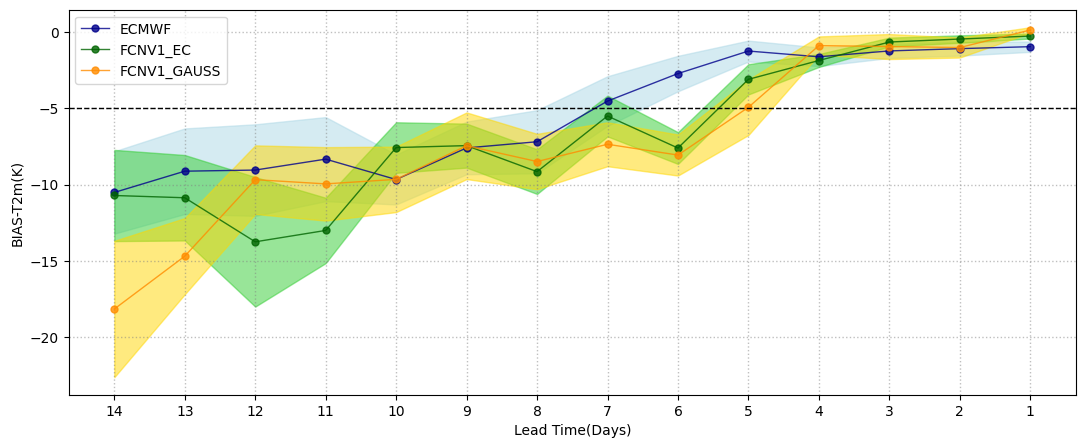

In [18]:
fig = plt.figure(figsize=(13,5))
ax = plt.axes()

x = np.linspace(1, 14, 14)


ax.plot(x, bias_median_ec_ens_box[0:14],marker='o',label='ECMWF',linewidth=1,markersize= 5,color = 'darkblue',alpha=0.8);
#ax.fill_between(x, bias_median_ec_ens_box - bias_std_dev_ec_ens_box, bias_median_ec_ens_box + bias_std_dev_ec_ens_box, color='lightblue', alpha=0.5)
ax.fill_between(x, bias_median_ec_ens_box[0:14]- bias_std_dev_ec_ens_box[0:14], bias_median_ec_ens_box[0:14] + bias_std_dev_ec_ens_box[0:14], color='lightblue', alpha=0.5)

ax.plot(x, bias_median_fcnv1_ec_ens_box[0:14],marker='o',label='FCNV1_EC',linewidth=1,markersize= 5,color = 'darkgreen',alpha=0.8);
ax.fill_between(x, bias_median_fcnv1_ec_ens_box[0:14]- bias_std_dev_fcnv1_ec_ens_box[0:14], bias_median_fcnv1_ec_ens_box[0:14] + bias_std_dev_fcnv1_ec_ens_box[0:14], color='limegreen', alpha=0.5)

ax.plot(x, bias_median_fcnv1_era_ens_box[0:14],marker='o',label='FCNV1_GAUSS',linewidth=1,markersize= 5,color = 'darkorange',alpha=0.8);
ax.fill_between(x, bias_median_fcnv1_era_ens_box[0:14] - bias_std_dev_fcnv1_era_ens_box[0:14], bias_median_fcnv1_era_ens_box[0:14] + bias_std_dev_fcnv1_era_ens_box[0:14], color='gold', alpha=0.5)

#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
#ax.axhline(-5, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
ax.axhline(-5, color='black', linestyle='--',linewidth=1)
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('BIAS-T2m(K)')
plt.xlabel('Lead Time(Days)')#should be from lager value to smaill value
ax.legend()
#plt.savefig('/home/kit/imk-tro/gj5173/result_0415/fcnv1_line_plot_0629_bias_t2m_1_withOUTbaseline_5k.png', bbox_inches='tight',dpi=200)

In [6]:
bias_std_dev_fcnv1_era_ens_box

<xarray.DataArray (dim_0: 15)>
array([4.47267336, 2.49854398, 2.24984002, 2.40997914, 2.14624631,
       2.18613052, 1.81559019, 1.44106492, 1.34470117, 1.81948609,
       0.603637  , 0.82068602, 0.65457404, 0.1839894 , 0.        ])
Dimensions without coordinates: dim_0

In [7]:
bias_std_dev_fcnv1_ec_ens_box

<xarray.DataArray (dim_0: 15)>
array([2.9909288 , 2.80223093, 4.24835564, 2.14187466, 1.65809292,
       1.44156127, 1.46384547, 1.33572024, 1.04231396, 0.99188679,
       0.42348192, 0.28773526, 0.24491064, 0.16293161, 0.27220395])
Dimensions without coordinates: dim_0

In [35]:
plt.rcParams.update({
    'font.size': 15,      # Default font size
    'axes.titlesize': 15,  # Font size for plot titles
    'axes.labelsize': 15,  # Font size for x and y labels
    'xtick.labelsize': 15,  # Font size for x tick labels
    'ytick.labelsize': 15,  # Font size for y tick labels
    'legend.fontsize': 13  # Font size for legend
})

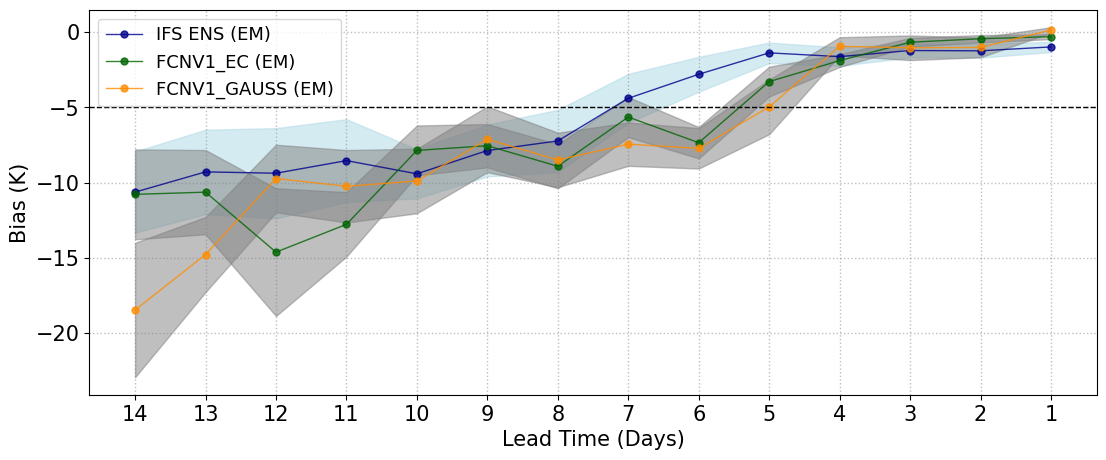

In [36]:
fig = plt.figure(figsize=(13,5))
ax = plt.axes()

x = np.linspace(1, 14, 14)


ax.plot(x, bias_mean_ec_ens_box[0:14],marker='o',label='IFS ENS (EM)',linewidth=1,markersize= 5,color = 'darkblue',alpha=0.8);
#ax.fill_between(x, bias_median_ec_ens_box - bias_std_dev_ec_ens_box, bias_median_ec_ens_box + bias_std_dev_ec_ens_box, color='lightblue', alpha=0.5)
ax.fill_between(x, bias_mean_ec_ens_box[0:14]- bias_std_dev_ec_ens_box[0:14], bias_mean_ec_ens_box[0:14] + bias_std_dev_ec_ens_box[0:14], color='lightblue', alpha=0.5)

ax.plot(x, bias_mean_fcnv1_ec_ens_box[0:14],marker='o',label='FCNV1_EC (EM)',linewidth=1,markersize= 5,color = 'darkgreen',alpha=0.8);
ax.fill_between(x, bias_mean_fcnv1_ec_ens_box[0:14]- bias_std_dev_fcnv1_ec_ens_box[0:14], bias_mean_fcnv1_ec_ens_box[0:14] + bias_std_dev_fcnv1_ec_ens_box[0:14], color='grey', alpha=0.5)

ax.plot(x, bias_mean_fcnv1_era_ens_box[0:14],marker='o',label='FCNV1_GAUSS (EM)',linewidth=1,markersize= 5,color = 'darkorange',alpha=0.8);
ax.fill_between(x, bias_mean_fcnv1_era_ens_box[0:14] - bias_std_dev_fcnv1_era_ens_box[0:14], bias_mean_fcnv1_era_ens_box[0:14] + bias_std_dev_fcnv1_era_ens_box[0:14], color='grey', alpha=0.5)

#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
#ax.axhline(-5, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
ax.axhline(-5, color='black', linestyle='--',linewidth=1)
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('Bias (K)')
plt.xlabel('Lead Time (Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/final_line_fcnv1_t2m.png', bbox_inches='tight',dpi=200)

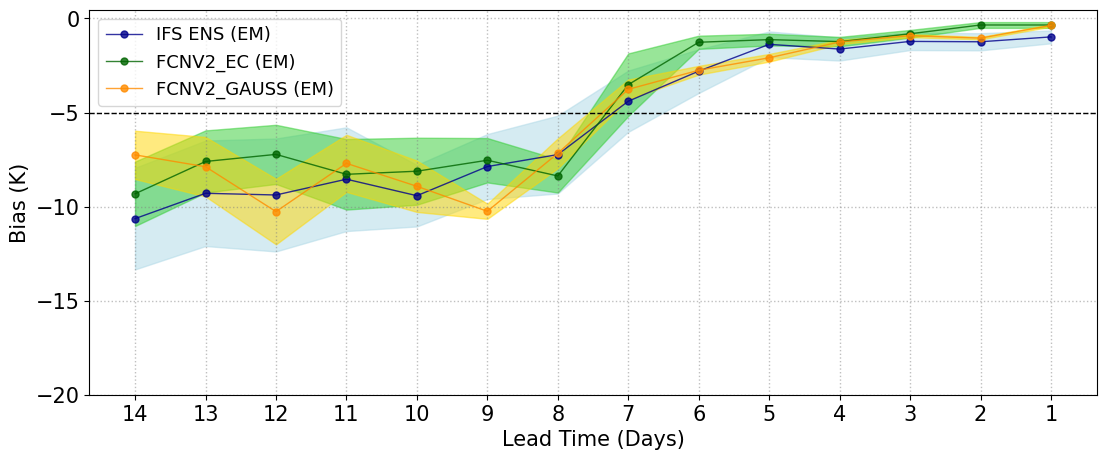

In [48]:
fig = plt.figure(figsize=(13,5))
ax = plt.axes()





x = np.linspace(1, 14, 14)
ax.plot(x, ds_mean_ec_ens_box, marker='o', label='IFS ENS (EM)', linewidth=1, markersize=5, color='darkblue', alpha=0.8)
ax.fill_between(x1, ds_mean_ec_ens_box - ds_std_dev_ec_ens_box, ds_mean_ec_ens_box + ds_std_dev_ec_ens_box, color='lightblue', alpha=0.5)
ax.plot(x, ds_mean_fcnv2_ec_ens_box[:], marker='o', label='FCNV2_EC (EM)', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
ax.fill_between(x1, ds_mean_fcnv2_ec_ens_box - ds_std_dev_fcnv2_ec_ens_box, ds_mean_fcnv2_ec_ens_box + ds_std_dev_fcnv2_ec_ens_box, color='limegreen', alpha=0.5)
ax.plot(x, ds_mean_fcnv2_era_ens_box[:], marker='o', label='FCNV2_GAUSS (EM)', linewidth=1, markersize=5, color='darkorange', alpha=0.8)
ax.fill_between(x, ds_mean_fcnv2_era_ens_box - ds_std_dev_fcnv2_era_ens_box, ds_mean_fcnv2_era_ens_box + ds_std_dev_fcnv2_era_ens_box, color='gold', alpha=0.5)
ax.axhline(-5, color='black', linestyle='--', linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
ax.set_yticks([-20, -15, -10, -5, 0])
ax.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)

ax.set_ylabel('Bias (K)')
ax.set_xlabel('Lead Time (Days)')
ax.legend()

plt.savefig('/home/kit/imktro/gj5173/08_06_plots/final_line_fcnv2_t2m.png', bbox_inches='tight',dpi=200)

In [ ]:
#cf#########################

In [55]:
bias_ec_t2m_box_0629_mean

array([-11.78792972, -10.72736011, -10.26977099,  -6.1757056 ,
        -8.85640948,  -8.04666492,  -7.63823642,  -2.88565097,
        -1.97053744,  -0.44919223,  -1.26565539,  -0.91337039,
        -0.83924518,  -0.76942157,  -1.40740664])

In [56]:
bias_fcnv1_era_t2m_box_0629_mean

array([-12.75788068,  -9.64155023, -10.29790983, -11.86880194,
        -6.06093801,  -6.73168129,  -9.96684679,  -6.61323139,
        -7.93577632,  -2.82005134,  -0.56909077,  -0.82275146,
        -0.7286351 ,   0.24042674,   0.23384904])

In [59]:
bias_fcnv1_ec_t2m_box_0629_mean

array([-10.72669404,  -8.79664473, -10.2827787 , -13.75435073,
        -6.39752577,  -7.23122077,  -9.51916881,  -5.32716868,
        -7.66332439,  -2.74818667,  -1.72006012,  -0.57102417,
        -0.39032255,  -0.26658074, -23.44873431])

In [61]:

%store -r ds_fcnv2_ec_t2m_box_0629_mean
%store -r ds_fcnv2_era_t2m_box_0629_mean


In [70]:
bias_fcnv2_era_cf_0629 = ds_fcnv2_era_t2m_box_0629_mean - ds_era5_t2m_box_mean[15]
bias_fcnv2_ec_cf_0629 = ds_fcnv2_ec_t2m_box_0629_mean - ds_era5_t2m_box_mean[15]

In [72]:
%store ds_bias_pangu_t2m_na_0629_box_mean

Stored 'ds_bias_pangu_t2m_na_0629_box_mean' (DataArray)


In [73]:
ds_bias_pangu_t2m_na_0629_box_mean

<xarray.DataArray '2m_temperature' (time: 10)> Size: 40B
dask.array<mean_agg-aggregate, shape=(10,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time                  (time) int64 80B 0 1 2 3 4 5 6 7 8 9
    prediction_timedelta  (time) timedelta64[ns] 80B 10 days 9 days ... 1 days

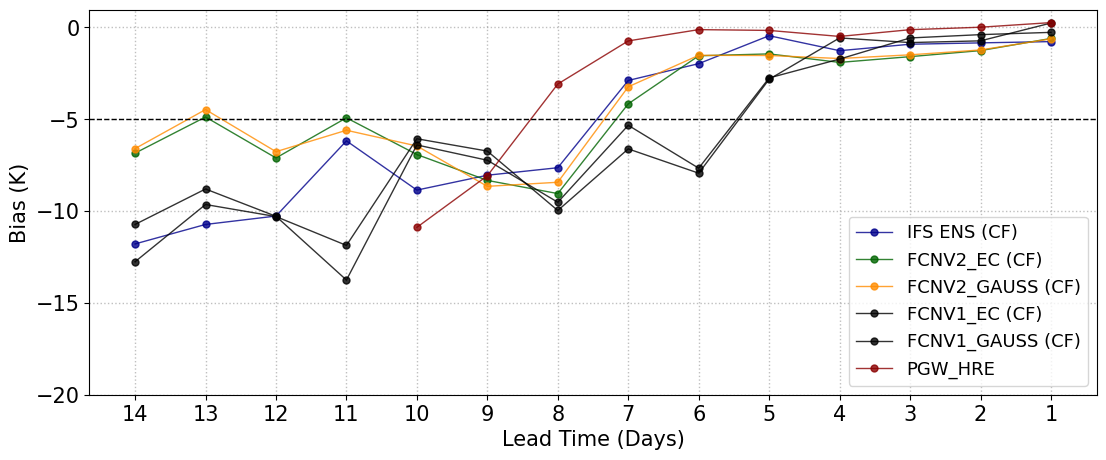

In [89]:
fig = plt.figure(figsize=(13,5))
ax = plt.axes()





x = np.linspace(1, 14, 14)
ax.plot(x, bias_ec_t2m_box_0629_mean[0:14], marker='o', label='IFS ENS (CF)', linewidth=1, markersize=5, color='darkblue', alpha=0.8)

ax.plot(x, bias_fcnv2_ec_cf_0629[1:15], marker='o', label='FCNV2_EC (CF)', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
ax.plot(x, bias_fcnv2_era_cf_0629[1:15], marker='o', label='FCNV2_GAUSS (CF)', linewidth=1, markersize=5, color='darkorange', alpha=0.8)

ax.plot(x, bias_fcnv1_ec_t2m_box_0629_mean[0:14], marker='o', label='FCNV1_EC (CF)', linewidth=1, markersize=5, color='black', alpha=0.8)
ax.plot(x, bias_fcnv1_era_t2m_box_0629_mean[0:14], marker='o', label='FCNV1_GAUSS (CF)', linewidth=1, markersize=5, color='black', alpha=0.8)
ax.plot(x[4:14], ds_bias_pangu_t2m_na_0629_box_mean, marker='o', label='PGW_HRE', linewidth=1, markersize=5, color='darkred', alpha=0.8)

ax.axhline(-5, color='black', linestyle='--', linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
ax.set_yticks([-20, -15, -10, -5, 0])
ax.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)

ax.set_ylabel('Bias (K)')
ax.set_xlabel('Lead Time (Days)')
ax.legend()

plt.savefig('/home/kit/imktro/gj5173/08_06_plots/final_line_cf_t2m.png', bbox_inches='tight',dpi=200)

In [ ]:
##################################### only took the lead time of median when it first across the -5 line ########################################################################

In [127]:
fcnv1_ec_ens_box_t2m_worst = bias_median_fcnv1_ec_ens_box - bias_std_dev_fcnv1_ec_ens_box
fcnv1_ec_ens_box_t2m_best = bias_median_fcnv1_ec_ens_box + bias_std_dev_fcnv1_ec_ens_box

fcnv1_era_ens_box_t2m_worst = bias_median_fcnv1_era_ens_box - bias_std_dev_fcnv1_era_ens_box
fcnv1_era_ens_box_t2m_best = bias_median_fcnv1_era_ens_box + bias_std_dev_fcnv1_era_ens_box

ec_ens_box_t2m_worst = bias_median_ec_ens_box - bias_std_dev_ec_ens_box
ec_ens_box_t2m_best = bias_median_ec_ens_box + bias_std_dev_ec_ens_box

In [128]:
fcnv1_ec_ens_box_t2m_worst = bias_mean_fcnv1_ec_ens_box - bias_std_dev_fcnv1_ec_ens_box
fcnv1_ec_ens_box_t2m_best = bias_mean_fcnv1_ec_ens_box + bias_std_dev_fcnv1_ec_ens_box

fcnv1_era_ens_box_t2m_worst = bias_mean_fcnv1_era_ens_box - bias_std_dev_fcnv1_era_ens_box
fcnv1_era_ens_box_t2m_best = bias_mean_fcnv1_era_ens_box + bias_std_dev_fcnv1_era_ens_box

ec_ens_box_t2m_worst = bias_mean_ec_ens_box - bias_std_dev_ec_ens_box
ec_ens_box_t2m_best = bias_mean_ec_ens_box + bias_std_dev_ec_ens_box

In [130]:
import numpy as np
from scipy.interpolate import interp1d

def calculate_lead_time(ds_median):
    lead_time = np.linspace(1, 14, 14)
    fine_lead_times = np.linspace(1, 14, 1000)
    
    interp_func = interp1d(lead_time, ds_median[::-1], kind='linear')
   
    interpolated_ds = interp_func(fine_lead_times)
    lead_time_index = np.argmax(interpolated_ds< -5)
    lead_time = fine_lead_times[lead_time_index]
    return lead_time

In [137]:
lt_fcnv1_ec_median = calculate_lead_time(bias_median_fcnv1_ec_ens_box[0:14])
lt_fcnv1_ec_mean = calculate_lead_time(bias_mean_fcnv1_ec_ens_box[0:14])
lt_fcnv1_ec_best = calculate_lead_time(fcnv1_ec_ens_box_t2m_best[0:14])
lt_fcnv1_ec_worst = calculate_lead_time(fcnv1_ec_ens_box_t2m_worst[0:14])

lt_ec_median = calculate_lead_time(bias_median_ec_ens_box[0:14])
lt_ec_mean = calculate_lead_time(bias_mean_ec_ens_box[0:14])
lt_ec_best = calculate_lead_time(ec_ens_box_t2m_best[0:14])
lt_ec_worst = calculate_lead_time(ec_ens_box_t2m_worst[0:14])

lt_fcnv1_era_median = calculate_lead_time(bias_median_fcnv1_era_ens_box[0:14])
lt_fcnv1_era_mean = calculate_lead_time(bias_mean_fcnv1_era_ens_box[0:14])
lt_fcnv1_era_best = calculate_lead_time(fcnv1_era_ens_box_t2m_best[0:14])
lt_fcnv1_era_worst = calculate_lead_time(fcnv1_era_ens_box_t2m_worst[0:14])

In [138]:
lt_fcnv1_era = [lt_fcnv1_era_mean,lt_fcnv1_era_best,lt_fcnv1_era_worst]
lt_fcnv1_ec = [lt_fcnv1_ec_mean,lt_fcnv1_ec_best,lt_fcnv1_ec_worst]
lt_ec = [lt_ec_mean,lt_ec_best,lt_ec_worst]

In [139]:
%store -r bias_fcnv2_era_t2m_box_0629_ens_mean 
%store -r bias_fcnv2_ec_t2m_box_0629_ens_mean 


In [140]:
def calculate_stats_as_xarray(data):
    mean_values = [np.mean(data[i, :]) for i in range(14)]
    median_values = [statistics.median(data[i, :]) for i in range(14)]
    std_dev_values = [np.std(data[i, :]) for i in range(14)]
    
    mean_da = xr.DataArray(mean_values, dims='member', name='mean')
    median_da = xr.DataArray(median_values, dims='member', name='median')
    std_dev_da = xr.DataArray(std_dev_values, dims='member', name='std_dev')
    
    return mean_da, median_da, std_dev_da

In [141]:

ds_mean_fcnv2_era_ens_box, ds_median_fcnv2_era_ens_box, ds_std_dev_fcnv2_era_ens_box = calculate_stats_as_xarray(bias_fcnv2_era_t2m_box_0629_ens_mean)
ds_mean_fcnv2_ec_ens_box, ds_median_fcnv2_ec_ens_box, ds_std_dev_fcnv2_ec_ens_box = calculate_stats_as_xarray(bias_fcnv2_ec_t2m_box_0629_ens_mean)


In [142]:
fcnv2_ec_ens_box_t2m_worst = ds_median_fcnv2_ec_ens_box - ds_std_dev_fcnv2_ec_ens_box
fcnv2_ec_ens_box_t2m_best = ds_median_fcnv2_ec_ens_box + ds_std_dev_fcnv2_ec_ens_box

fcnv2_era_ens_box_t2m_worst = ds_median_fcnv2_era_ens_box - ds_std_dev_fcnv2_era_ens_box
fcnv2_era_ens_box_t2m_best = ds_median_fcnv2_era_ens_box + ds_std_dev_fcnv2_era_ens_box

In [143]:
fcnv2_ec_ens_box_t2m_worst = ds_mean_fcnv2_ec_ens_box - ds_std_dev_fcnv2_ec_ens_box
fcnv2_ec_ens_box_t2m_best = ds_mean_fcnv2_ec_ens_box + ds_std_dev_fcnv2_ec_ens_box

fcnv2_era_ens_box_t2m_worst = ds_mean_fcnv2_era_ens_box - ds_std_dev_fcnv2_era_ens_box
fcnv2_era_ens_box_t2m_best = ds_mean_fcnv2_era_ens_box + ds_std_dev_fcnv2_era_ens_box

In [144]:
import numpy as np
from scipy.interpolate import interp1d

def calculate_lead_time_fcnv2(ds_median):
    lead_time = np.linspace(1, 14, 14)
    fine_lead_times = np.linspace(1, 14, 1000)
    
    interp_func = interp1d(lead_time, ds_median[::-1], kind='linear')
   
    interpolated_ds = interp_func(fine_lead_times)
    lead_time_index = np.argmax(interpolated_ds< -5)
    lead_time = fine_lead_times[lead_time_index]
    return lead_time

In [145]:
bias_median_fcnv1_ec_ens_box[::-1]

<xarray.DataArray (dim_0: 15)> Size: 120B
array([ -1.33906703,  -0.26360084,  -0.45923723,  -0.65481797,
        -1.86692718,  -3.10192712,  -7.60799989,  -5.50838891,
        -9.15582433,  -7.44911539,  -7.57589249, -13.01218205,
       -13.75875137, -10.86849173, -10.72025287])
Dimensions without coordinates: dim_0

In [102]:
bias_median_ec_ens_box

<xarray.DataArray (dim_0: 15)>
array([-10.5206911 ,  -9.12596271,  -9.05256824,  -8.33553813,
        -9.67289104,  -7.59960406,  -7.1952019 ,  -4.52820346,
        -2.72256473,  -1.24613467,  -1.62297381,  -1.23919894,
        -1.08930873,  -0.96006038,  -1.33906703])
Dimensions without coordinates: dim_0

In [100]:
ds_median_fcnv2_era_ens_box[::-1]

<xarray.DataArray 'median' (member: 14)>
array([ -0.37535095,  -1.04801941,  -0.91537476,  -1.22294617,
        -2.04283142,  -2.74916077,  -3.72950745,  -7.27163696,
       -10.2933197 ,  -9.11932373,  -7.8361969 , -10.54341125,
        -7.858078  ,  -6.93692017])
Dimensions without coordinates: member

In [146]:
lt_fcnv2_era_median = calculate_lead_time_fcnv2(ds_median_fcnv2_era_ens_box)

lt_fcnv2_era_best = calculate_lead_time_fcnv2(fcnv2_era_ens_box_t2m_best)
lt_fcnv2_era_worst = calculate_lead_time_fcnv2(fcnv2_era_ens_box_t2m_worst)

lt_fcnv2_ec_median = calculate_lead_time_fcnv2(ds_median_fcnv2_ec_ens_box)
lt_fcnv2_ec_best = calculate_lead_time_fcnv2(fcnv2_ec_ens_box_t2m_best)
lt_fcnv2_ec_worst = calculate_lead_time_fcnv2(fcnv2_ec_ens_box_t2m_worst)

In [147]:
lt_fcnv2_era_mean = calculate_lead_time_fcnv2(ds_mean_fcnv2_era_ens_box)

lt_fcnv2_era_best = calculate_lead_time_fcnv2(fcnv2_era_ens_box_t2m_best)
lt_fcnv2_era_worst = calculate_lead_time_fcnv2(fcnv2_era_ens_box_t2m_worst)

lt_fcnv2_ec_mean = calculate_lead_time_fcnv2(ds_mean_fcnv2_ec_ens_box)
lt_fcnv2_ec_best = calculate_lead_time_fcnv2(fcnv2_ec_ens_box_t2m_best)
lt_fcnv2_ec_worst = calculate_lead_time_fcnv2(fcnv2_ec_ens_box_t2m_worst)

In [148]:
lt_fcnv2_era = [lt_fcnv2_era_median,lt_fcnv2_era_best,lt_fcnv2_era_worst]
lt_fcnv2_ec = [lt_fcnv2_ec_median,lt_fcnv2_ec_best,lt_fcnv2_ec_worst]
lt_ec = [lt_ec_median,lt_ec_best,lt_ec_worst]

In [149]:
lt_fcnv2_era = [lt_fcnv2_era_mean,lt_fcnv2_era_best,lt_fcnv2_era_worst]
lt_fcnv2_ec = [lt_fcnv2_ec_mean,lt_fcnv2_ec_best,lt_fcnv2_ec_worst]
lt_ec = [lt_ec_mean,lt_ec_best,lt_ec_worst]

In [191]:
lt_ec_mean

7.22022022022022

In [151]:
15-lt_ec[0]

7.77977977977978

In [193]:
lt_fcnv1_era_mean

5.021021021021021

In [ ]:
############################ HORIZON OF CF ##############################################################

In [162]:
import numpy as np
from scipy.interpolate import interp1d

def calculate_lead_time_pangu(ds_median):
    lead_time = np.linspace(1, 10, 10)
    fine_lead_times = np.linspace(1, 10, 1000)
    
    interp_func = interp1d(lead_time, ds_median[::-1], kind='linear')
   
    interpolated_ds = interp_func(fine_lead_times)
    lead_time_index = np.argmax(interpolated_ds< -5)
    lead_time = fine_lead_times[lead_time_index]
    return lead_time

In [163]:
lt_ec_cf_mean = calculate_lead_time(bias_ec_t2m_box_0629_mean[0:14])
lt_fcnv2_ec_cf_mean = calculate_lead_time(bias_fcnv2_ec_cf_0629[1:15])
lt_fcnv2_era_cf_mean = calculate_lead_time(bias_fcnv2_era_cf_0629[1:15])
lt_fcnv1_ec_cf_mean = calculate_lead_time(bias_fcnv1_ec_t2m_box_0629_mean[0:14])
lt_fcnv1_era_cf_mean = calculate_lead_time(bias_fcnv1_era_t2m_box_0629_mean[0:14])
lt_pangu_hres_mean = calculate_lead_time_pangu(ds_bias_pangu_t2m_na_0629_box_mean)

In [187]:
lt_ec_cf_mean

7.454454454454455

(14.0, 1.0)

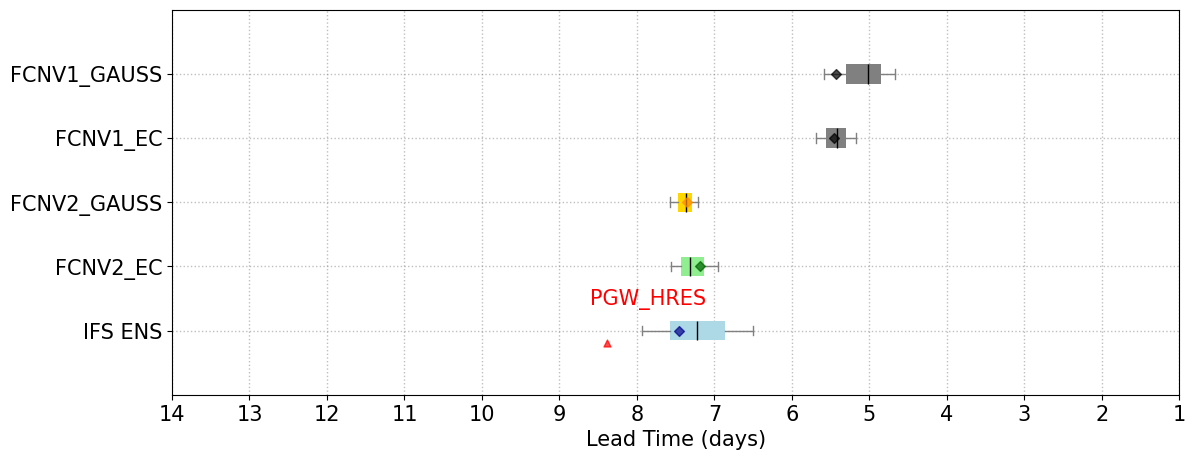

In [169]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(13, 5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold','grey','grey']
box_positions = [0,0.5,1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['IFS ENS', 'FCNV2_EC', 'FCNV2_GAUSS','FCNV1_EC','FCNV1_GAUSS']  # Make sure the length matches the number of boxes

# Use enumerate to iterate over both the index and the color
for i, (data, color, position) in enumerate(zip([lt_ec, lt_fcnv2_ec, lt_fcnv2_era,lt_fcnv1_ec, lt_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='black'),flierprops=outlier_properties)



points_1 = ax.scatter(lt_ec_cf_mean, box_positions[0], color='darkblue', marker='D', zorder=5, s=25, alpha=0.7)
points_2 = ax.scatter(lt_fcnv2_ec_cf_mean, box_positions[1], color='darkgreen', marker='D', zorder=5, s=25, alpha=0.7)
points_3 = ax.scatter(lt_fcnv2_era_cf_mean, box_positions[2], color='darkorange', marker='D', zorder=5, s=25, alpha=0.7)
points_4 = ax.scatter(lt_fcnv1_ec_cf_mean, box_positions[3], color='black', marker='D', zorder=5, s=25, alpha=0.7)
points_5 = ax.scatter(lt_fcnv1_era_cf_mean, box_positions[4], color='black', marker='D', zorder=5, s=25, alpha=0.7)
points_6 = ax.scatter(lt_pangu_hres_mean, -0.1, color='red', marker='^', zorder=5, s=25, alpha=0.7)


label = 'PGW_HRES'  # Replace with your actual label
x = lt_pangu_hres_mean +0.4
y = box_positions[0]+0.2
ax.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha='left', color='red')



# Set the y-axis label
ax.set_xlabel('Lead Time (days)')

#tick_labels = [str(i) for i in range(14, 0, -1)]
#plt.gca().set_xticks(range(1, len(tick_labels) + 1))
#plt.gca().set_xticklabels(tick_labels)
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.xticks(np.arange(1, 15, 1))
plt.gca().invert_xaxis()
plt.xlim(14, 1)
#bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
#ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
#plt.savefig('/home/kit/imk-tro/gj5173/result1/leadtime_gain_t2m_5k_v1v2.png', bbox_inches='tight',dpi=100)


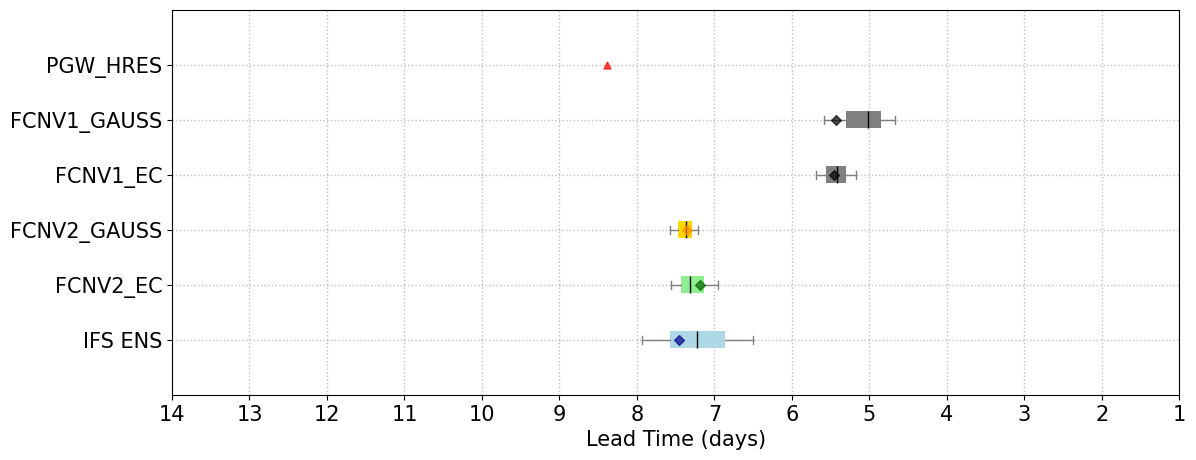

In [181]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_ec, lt_fcnv2_ec, lt_fcnv2_era, lt_fcnv1_ec, lt_fcnv1_era, lt_pangu_hres_mean)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(13, 5))

# Define colors, positions, and labels for each box
box_colors = ['lightblue', 'lightgreen', 'gold', 'grey', 'grey']
box_positions = [0, 0.5, 1, 1.5, 2]
box_labels = ['IFS ENS', 'FCNV2_EC', 'FCNV2_GAUSS', 'FCNV1_EC', 'FCNV1_GAUSS']

# Plot each box with its specific properties
for i, (data, color, position) in enumerate(zip([lt_ec, lt_fcnv2_ec, lt_fcnv2_era, lt_fcnv1_ec, lt_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey', linewidth=1)
    cap_properties = dict(color='grey', linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')

    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]], 
                vert=False, boxprops=box_properties, whiskerprops=whisker_properties,
                capprops=cap_properties, showfliers=True, patch_artist=True,
                medianprops=dict(color='black'), flierprops=outlier_properties)

# Scatter plot for each point
points_1 = ax.scatter(lt_ec_cf_mean, box_positions[0], color='darkblue', marker='D', zorder=5, s=25, alpha=0.7)
points_2 = ax.scatter(lt_fcnv2_ec_cf_mean, box_positions[1], color='darkgreen', marker='D', zorder=5, s=25, alpha=0.7)
points_3 = ax.scatter(lt_fcnv2_era_cf_mean, box_positions[2], color='darkorange', marker='D', zorder=5, s=25, alpha=0.7)
points_4 = ax.scatter(lt_fcnv1_ec_cf_mean, box_positions[3], color='black', marker='D', zorder=5, s=25, alpha=0.7)
points_5 = ax.scatter(lt_fcnv1_era_cf_mean, box_positions[4], color='black', marker='D', zorder=5, s=25, alpha=0.7)

# Position the sixth point on a new row
new_row_position = max(box_positions) + 0.5  # Position it below the last box
points_6 = ax.scatter(lt_pangu_hres_mean, new_row_position, color='red', marker='^', zorder=5, s=25, alpha=0.7)

# Annotate the specific point
#label = 'PGW_HRES'
#x = lt_pangu_hres_mean + 0.4
#y = new_row_position + 0.2
#ax.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha='left', color='red')

# Set the x-axis label
ax.set_xlabel('Lead Time (days)')


# Add the new label for the y-axis
all_labels = box_labels + ['PGW_HRES']
plt.yticks(box_positions + [new_row_position], all_labels)

# Configure the x-axis
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.xticks(np.arange(1, 15, 1))
plt.gca().invert_xaxis()
plt.xlim(14, 1)

# Adjust y-axis limits to accommodate the new row
plt.ylim(-0.5, new_row_position + 0.5)

# Save the figure
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/forecast_horizon_t2m.png', bbox_inches='tight',dpi=100)

# Display the plot
plt.show()

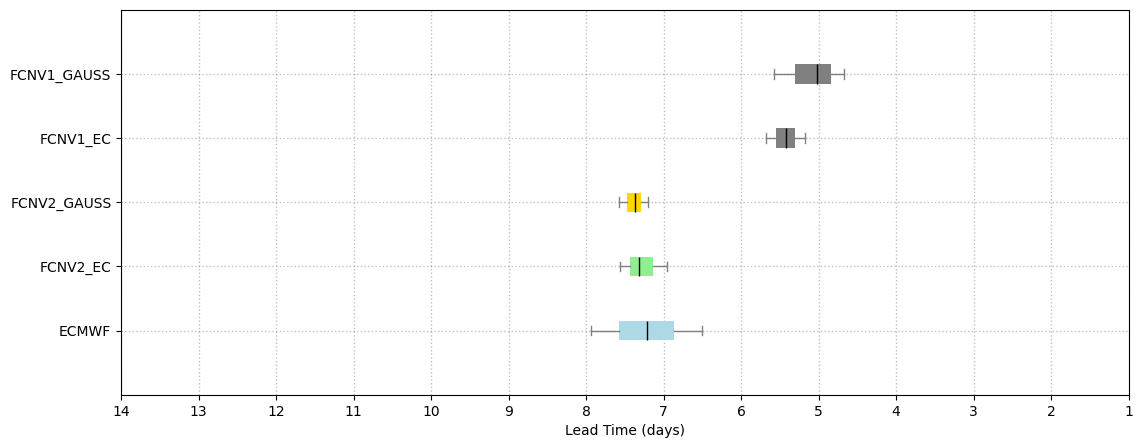

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(13, 5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold','grey','grey']
box_positions = [0,0.5,1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV2_EC', 'FCNV2_GAUSS','FCNV1_EC','FCNV1_GAUSS']  # Make sure the length matches the number of boxes

# Use enumerate to iterate over both the index and the color
for i, (data, color, position) in enumerate(zip([lt_ec, lt_fcnv2_ec, lt_fcnv2_era,lt_fcnv1_ec, lt_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='black'),flierprops=outlier_properties)

# Set the y-axis label
ax.set_xlabel('Lead Time (days)')
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#tick_labels = [str(i) for i in range(14, 0, -1)]
#plt.gca().set_xticks(range(1, len(tick_labels) + 1))
#plt.gca().set_xticklabels(tick_labels)
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
#bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
#ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
plt.savefig('/home/kit/imk-tro/gj5173/result1/leadtime_gain_t2m_5k_v1v2_mean.png', bbox_inches='tight',dpi=100)

In [102]:
%store -r bias_fcnv2_era_t2m_box_0629_ens_mean 
%store -r bias_fcnv2_ec_t2m_box_0629_ens_mean 
%store -r bias_ec_t2m_box_0629_ens_mean

In [103]:
def calculate_stats_as_xarray(data):
    mean_values = [np.mean(data[i, :]) for i in range(14)]
    median_values = [statistics.median(data[i, :]) for i in range(14)]
    std_dev_values = [np.std(data[i, :]) for i in range(14)]
    
    mean_da = xr.DataArray(mean_values, dims='member', name='mean')
    median_da = xr.DataArray(median_values, dims='member', name='median')
    std_dev_da = xr.DataArray(std_dev_values, dims='member', name='std_dev')
    
    return mean_da, median_da, std_dev_da

In [104]:

ds_mean_fcnv2_era_ens_box, ds_median_fcnv2_era_ens_box, ds_std_dev_fcnv2_era_ens_box = calculate_stats_as_xarray(bias_fcnv2_era_t2m_box_0629_ens_mean)
ds_mean_fcnv2_ec_ens_box, ds_median_fcnv2_ec_ens_box, ds_std_dev_fcnv2_ec_ens_box = calculate_stats_as_xarray(bias_fcnv2_ec_t2m_box_0629_ens_mean)
ds_mean_ec_ens_box, ds_median_ec_ens_box, ds_std_dev_ec_ens_box = calculate_stats_as_xarray(bias_ec_t2m_box_0629_ens_mean)


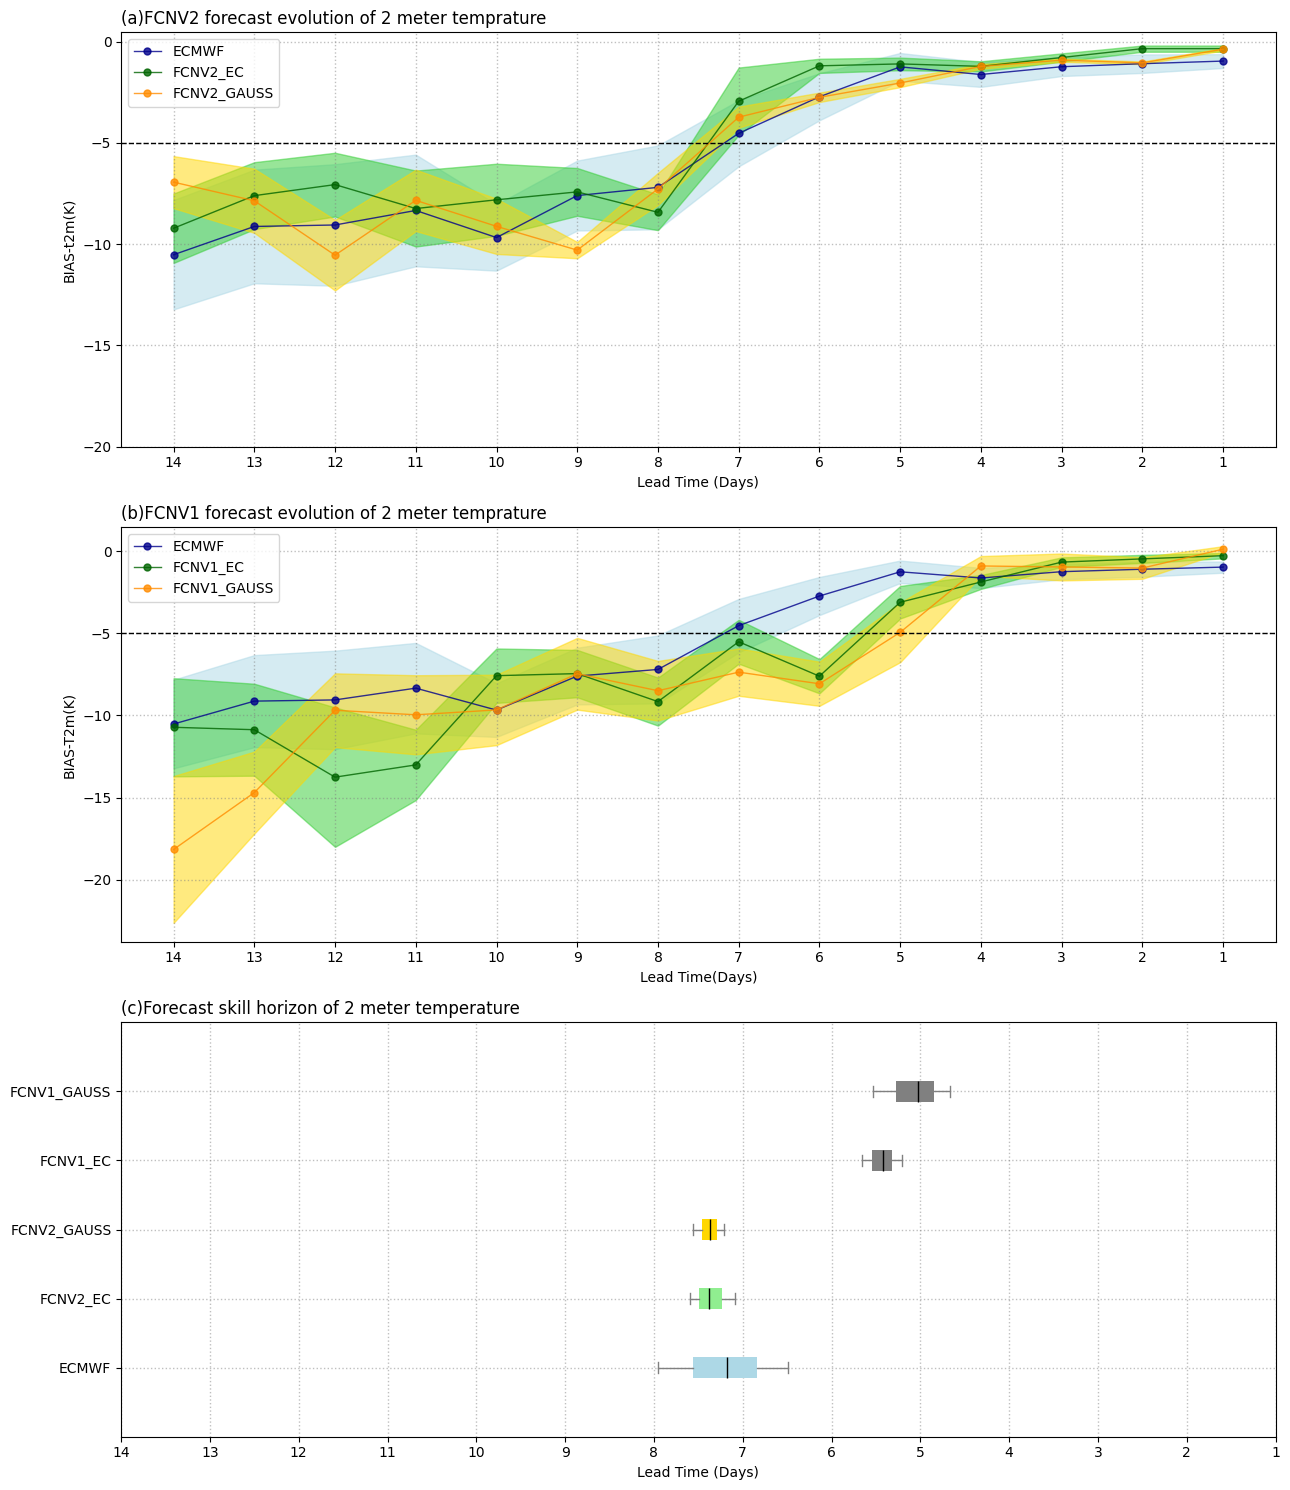

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13, 15))  # Create subplots with 2 rows and 1 column
gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 4, 0.5], wspace=0.5)
# First subplot
x1 = np.linspace(1, 14, 14)
ax1.plot(x1, ds_median_ec_ens_box, marker='o', label='ECMWF', linewidth=1, markersize=5, color='darkblue', alpha=0.8)
ax1.fill_between(x1, ds_median_ec_ens_box - ds_std_dev_ec_ens_box, ds_median_ec_ens_box + ds_std_dev_ec_ens_box, color='lightblue', alpha=0.5)
ax1.plot(x1, ds_median_fcnv2_ec_ens_box[:], marker='o', label='FCNV2_EC', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
ax1.fill_between(x1, ds_median_fcnv2_ec_ens_box - ds_std_dev_fcnv2_ec_ens_box, ds_median_fcnv2_ec_ens_box + ds_std_dev_fcnv2_ec_ens_box, color='limegreen', alpha=0.5)
ax1.plot(x1, ds_median_fcnv2_era_ens_box[:], marker='o', label='FCNV2_GAUSS', linewidth=1, markersize=5, color='darkorange', alpha=0.8)
ax1.fill_between(x1, ds_median_fcnv2_era_ens_box - ds_std_dev_fcnv2_era_ens_box, ds_median_fcnv2_era_ens_box + ds_std_dev_fcnv2_era_ens_box, color='gold', alpha=0.5)
ax1.axhline(-5, color='black', linestyle='--', linewidth=1)
ax1.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
ax1.set_yticks([-20, -15, -10, -5, 0])
ax1.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
ax1.set_title('(a)FCNV2 forecast evolution of 2 meter temprature',loc='left')
ax1.set_ylabel('BIAS-t2m(K)')
ax1.set_xlabel('Lead Time (Days)')
ax1.legend()

# Second subplot
x2 = np.linspace(1, 14, 14)
ax2.plot(x2, bias_median_ec_ens_box[0:14], marker='o', label='ECMWF', linewidth=1, markersize=5, color='darkblue', alpha=0.8)
ax2.fill_between(x2, bias_median_ec_ens_box[0:14] - bias_std_dev_ec_ens_box[0:14], bias_median_ec_ens_box[0:14] + bias_std_dev_ec_ens_box[0:14], color='lightblue', alpha=0.5)
ax2.plot(x2, bias_median_fcnv1_ec_ens_box[0:14], marker='o', label='FCNV1_EC', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
ax2.fill_between(x2, bias_median_fcnv1_ec_ens_box[0:14] - bias_std_dev_fcnv1_ec_ens_box[0:14], bias_median_fcnv1_ec_ens_box[0:14] + bias_std_dev_fcnv1_ec_ens_box[0:14], color='limegreen', alpha=0.5)
ax2.plot(x2, bias_median_fcnv1_era_ens_box[0:14], marker='o', label='FCNV1_GAUSS', linewidth=1, markersize=5, color='darkorange', alpha=0.8)
ax2.fill_between(x2, bias_median_fcnv1_era_ens_box[0:14] - bias_std_dev_fcnv1_era_ens_box[0:14], bias_median_fcnv1_era_ens_box[0:14] + bias_std_dev_fcnv1_era_ens_box[0:14], color='gold', alpha=0.5)
ax2.axhline(-5, color='black', linestyle='--', linewidth=1)
ax2.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
ax2.set_yticks([-20, -15, -10, -5, 0])
ax2.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
ax2.set_title('(b)FCNV1 forecast evolution of 2 meter temprature',loc='left')
ax2.set_ylabel('BIAS-T2m(K)')
ax2.set_xlabel('Lead Time(Days)')
ax2.legend()






# Add boxplot to the end
box_colors = ['lightblue', 'lightgreen', 'gold','grey','grey']
box_positions = [0,0.5,1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV2_EC', 'FCNV2_GAUSS','FCNV1_EC','FCNV1_GAUSS']  # Make sure the length matches the number of boxes

for i, (data, color, position) in enumerate(zip([lt_ec, lt_fcnv2_ec, lt_fcnv2_era,lt_fcnv1_ec, lt_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')

    ax3.boxplot(data, positions=[position], labels=[box_labels[i]],
                vert=False, boxprops=box_properties, whiskerprops=whisker_properties,
                capprops=cap_properties, showfliers=True, patch_artist=True,
                medianprops=dict(color='black'), flierprops=outlier_properties)
    ax3.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
    ax3.set_xlabel('Lead Time (Days)')
    ax3.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
    ax3.set_title('(c)Forecast skill horizon of 2 meter temperature',loc='left')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('/home/kit/imk-tro/gj5173/result1/forecast_skill_v1v2_t2m*3.png', bbox_inches='tight',dpi=100)


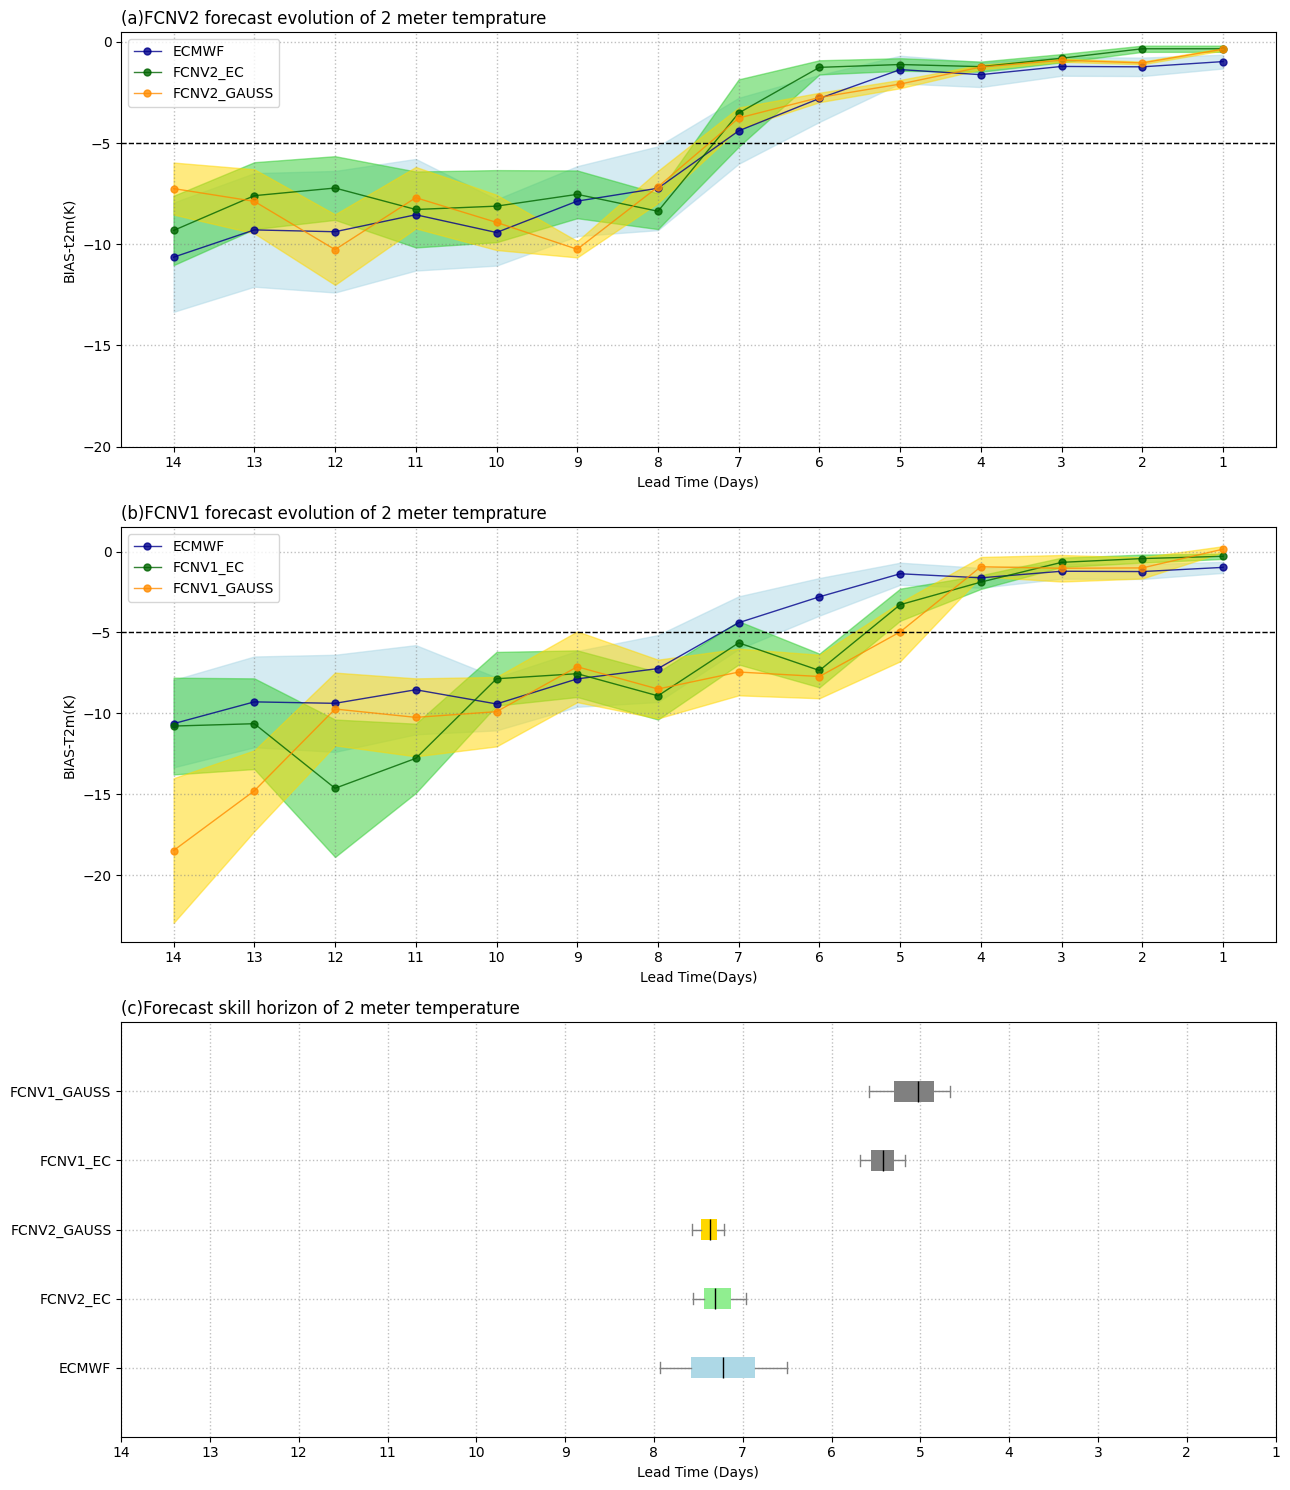

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13, 15))  # Create subplots with 2 rows and 1 column
gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 4, 0.5], wspace=0.5)
# First subplot
x1 = np.linspace(1, 14, 14)
ax1.plot(x1, ds_mean_ec_ens_box, marker='o', label='ECMWF', linewidth=1, markersize=5, color='darkblue', alpha=0.8)
ax1.fill_between(x1, ds_mean_ec_ens_box - ds_std_dev_ec_ens_box, ds_mean_ec_ens_box + ds_std_dev_ec_ens_box, color='lightblue', alpha=0.5)
ax1.plot(x1, ds_mean_fcnv2_ec_ens_box[:], marker='o', label='FCNV2_EC', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
ax1.fill_between(x1, ds_mean_fcnv2_ec_ens_box - ds_std_dev_fcnv2_ec_ens_box, ds_mean_fcnv2_ec_ens_box + ds_std_dev_fcnv2_ec_ens_box, color='limegreen', alpha=0.5)
ax1.plot(x1, ds_mean_fcnv2_era_ens_box[:], marker='o', label='FCNV2_GAUSS', linewidth=1, markersize=5, color='darkorange', alpha=0.8)
ax1.fill_between(x1, ds_mean_fcnv2_era_ens_box - ds_std_dev_fcnv2_era_ens_box, ds_mean_fcnv2_era_ens_box + ds_std_dev_fcnv2_era_ens_box, color='gold', alpha=0.5)
ax1.axhline(-5, color='black', linestyle='--', linewidth=1)
ax1.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
ax1.set_yticks([-20, -15, -10, -5, 0])
ax1.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
ax1.set_title('(a)FCNV2 forecast evolution of 2 meter temprature',loc='left')
ax1.set_ylabel('BIAS-t2m(K)')
ax1.set_xlabel('Lead Time (Days)')
ax1.legend()

# Second subplot
x2 = np.linspace(1, 14, 14)
ax2.plot(x2, bias_mean_ec_ens_box[0:14], marker='o', label='ECMWF', linewidth=1, markersize=5, color='darkblue', alpha=0.8)
ax2.fill_between(x2, bias_mean_ec_ens_box[0:14] - bias_std_dev_ec_ens_box[0:14], bias_mean_ec_ens_box[0:14] + bias_std_dev_ec_ens_box[0:14], color='lightblue', alpha=0.5)
ax2.plot(x2, bias_mean_fcnv1_ec_ens_box[0:14], marker='o', label='FCNV1_EC', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
ax2.fill_between(x2, bias_mean_fcnv1_ec_ens_box[0:14] - bias_std_dev_fcnv1_ec_ens_box[0:14], bias_mean_fcnv1_ec_ens_box[0:14] + bias_std_dev_fcnv1_ec_ens_box[0:14], color='limegreen', alpha=0.5)
ax2.plot(x2, bias_mean_fcnv1_era_ens_box[0:14], marker='o', label='FCNV1_GAUSS', linewidth=1, markersize=5, color='darkorange', alpha=0.8)
ax2.fill_between(x2, bias_mean_fcnv1_era_ens_box[0:14] - bias_std_dev_fcnv1_era_ens_box[0:14], bias_mean_fcnv1_era_ens_box[0:14] + bias_std_dev_fcnv1_era_ens_box[0:14], color='gold', alpha=0.5)
ax2.axhline(-5, color='black', linestyle='--', linewidth=1)
ax2.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
ax2.set_yticks([-20, -15, -10, -5, 0])
ax2.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
ax2.set_title('(b)FCNV1 forecast evolution of 2 meter temprature',loc='left')
ax2.set_ylabel('BIAS-T2m(K)')
ax2.set_xlabel('Lead Time(Days)')
ax2.legend()






# Add boxplot to the end
box_colors = ['lightblue', 'lightgreen', 'gold','grey','grey']
box_positions = [0,0.5,1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV2_EC', 'FCNV2_GAUSS','FCNV1_EC','FCNV1_GAUSS']  # Make sure the length matches the number of boxes

for i, (data, color, position) in enumerate(zip([lt_ec, lt_fcnv2_ec, lt_fcnv2_era,lt_fcnv1_ec, lt_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')

    ax3.boxplot(data, positions=[position], labels=[box_labels[i]],
                vert=False, boxprops=box_properties, whiskerprops=whisker_properties,
                capprops=cap_properties, showfliers=True, patch_artist=True,
                medianprops=dict(color='black'), flierprops=outlier_properties)
    ax3.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
    ax3.set_xlabel('Lead Time (Days)')
    ax3.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
    ax3.set_title('(c)Forecast skill horizon of 2 meter temperature',loc='left')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('/home/kit/imk-tro/gj5173/result1/forecast_skill_v1v2_t2m*3_mean.png', bbox_inches='tight',dpi=100)

In [25]:
fcnv1_ec_ens_box_t2m_worst = bias_median_fcnv1_ec_ens_box - bias_std_dev_fcnv1_ec_ens_box
fcnv1_ec_ens_box_t2m_best = bias_median_fcnv1_ec_ens_box + bias_std_dev_fcnv1_ec_ens_box

In [24]:
bias_median_fcnv1_ec_ens_box + bias_std_dev_fcnv1_ec_ens_box

<xarray.DataArray (dim_0: 15)>
array([ -7.72932407,  -8.0662608 ,  -9.51039573, -10.87030739,
        -5.91779957,  -6.00755411,  -7.69197885,  -4.17266867,
        -6.56568593,  -2.11004033,  -1.44344526,  -0.36708271,
        -0.21432659,  -0.10066923,  -1.06686308])
Dimensions without coordinates: dim_0

In [ ]:
################################## lead time gain #############################################

In [ ]:
################################### for different threshold ###############################

In [166]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_ec_pf_15k=[]
lt_gain_ec_pf_10k=[]
lt_gain_ec_pf_5k=[]
interpolated_data=[]
index=[]
for i in range(1):
    data =bias_ec_t2m_box_0629_ens_mean[:,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 100)
    interpolated_data = interp_function(fine_x_values)
    for j in np.linspace(-10, -5, 6):
        index_value = np.where(interpolated_data > j)[0][0]
        index.append(index_value)
    #index_10k = np.where(interpolated_data > -10)[0][0]
    #index_5k = np.where(interpolated_data > -5)[0][0]
        x_value_15k = fine_x_values[index_value]
    #x_value_10k = fine_x_values[index_10k]
    #x_value_5k = fine_x_values[index_5k]
        lt_gain_ec_pf_15k.append(14-x_value_15k)
    #lt_gain_ec_pf_10k.append(14-x_value_10k)
    #lt_gain_ec_pf_5k.append(14-x_value_5k)
    


In [167]:
 np.linspace(-10, -5, 6)

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.])

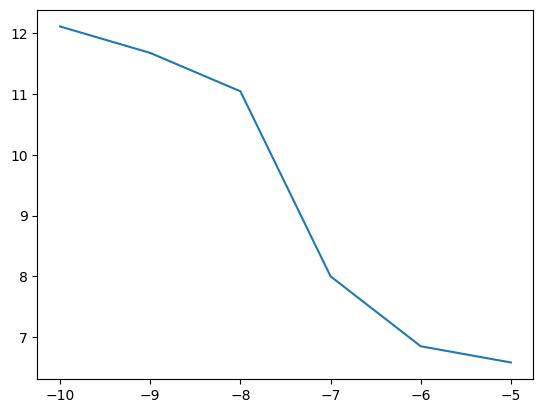

In [168]:
#lt_gain_ec_pf_15k = xr.DataArray(np.reshape(lt_gain_ec_pf_15k,(100,50)))
plt.plot(np.linspace(-10, -5, 6),lt_gain_ec_pf_15k)

In [87]:
 lt_gain_ec_pf_10k

[1.8918918918918919,
 0.0,
 0.0,
 0.014014014014014014,
 0.15415415415415415,
 1.8358358358358358,
 0.5885885885885885,
 0.0,
 0.0,
 1.6256256256256256,
 0.0,
 2.6766766766766765,
 0.0,
 0.028028028028028028,
 0.0,
 0.0,
 0.0,
 0.04204204204204204,
 0.6586586586586587,
 0.0,
 1.6816816816816818,
 3.195195195195195,
 0.9109109109109109,
 0.8688688688688688,
 1.2752752752752752,
 0.8408408408408409,
 0.6306306306306306,
 0.26626626626626626,
 2.8728728728728727,
 0.5045045045045045,
 0.3363363363363363,
 1.4014014014014013,
 0.5885885885885885,
 0.0,
 0.6586586586586587,
 0.0,
 0.5465465465465466,
 0.6166166166166166,
 0.12612612612612611,
 0.0,
 0.0,
 2.5225225225225225,
 0.0,
 0.0,
 0.0,
 0.8968968968968969,
 3.6016016016016015,
 0.0,
 0.0,
 0.16816816816816815]

In [ ]:
############################## for 5K as the threshold ###########################

In [8]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_ec_t2m_5k=[]
for i in range(50):
    data = bias_ec_t2m_box_0629_ens_mean[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < -5)[0][0]
    x_value = fine_x_values[index_of_first_point]
    #x_value_reverse = 11-x_value
    lt_gain_ec_t2m_5k.append(x_value)

In [16]:
 lt_gain_ec_t2m_5k

[6.6006006006006,
 7.67967967967968,
 8.338338338338339,
 7.4974974974974975,
 7.315315315315315,
 6.908908908908908,
 7.5675675675675675,
 7.791791791791792,
 7.7357357357357355,
 6.5025025025025025,
 6.796796796796797,
 6.894894894894895,
 7.231231231231231,
 7.315315315315315,
 8.366366366366366,
 6.922922922922923,
 7.161161161161161,
 7.049049049049049,
 7.81981981981982,
 6.25025025025025,
 7.147147147147147,
 7.049049049049049,
 8.52052052052052,
 6.922922922922923,
 7.315315315315315,
 6.936936936936937,
 6.754754754754755,
 5.801801801801802,
 7.581581581581582,
 7.511511511511512,
 8.31031031031031,
 7.81981981981982,
 6.516516516516517,
 6.6006006006006,
 7.301301301301301,
 6.754754754754755,
 7.46946946946947,
 6.628628628628628,
 7.95995995995996,
 6.488488488488488,
 7.217217217217217,
 5.8998998998999,
 7.1891891891891895,
 6.950950950950951,
 7.511511511511512,
 7.301301301301301,
 6.726726726726727,
 7.147147147147147,
 6.53053053053053,
 7.4274274274274275]

In [18]:
bias_fcnv1_ec_t2m_box_0629_ens_mean[0,:]

array([-13.2345487 ,  -8.12266238, -10.85395496, -14.66601434,
       -15.12038349, -14.32562582, -12.3452955 , -10.96823666,
        -4.79941275, -13.1759879 ,  -9.6035595 ,  -8.79425074,
       -15.00249859, -10.42173864,  -8.55612224,  -9.30688808,
        -4.16516297,  -8.7850047 ,  -9.6815622 , -14.06762291,
        -9.64893622, -10.14761749, -13.47247764,  -4.31829285,
       -10.55793118, -14.60002211, -12.42721432,  -8.09280134,
       -13.5307431 , -12.66632321, -11.31222093, -13.7043104 ,
       -14.90077667,  -9.41595768,  -7.28898986, -11.60552535,
        -9.47504955,  -5.93960198, -17.08076623, -13.36178219,
       -12.48574935, -11.47784165,  -6.09646492,  -9.40147435,
        -9.1346431 , -10.58655078,  -9.21564706, -13.21257354,
       -11.48564139,  -6.74620707])

In [20]:
lt_gain_fcnv1_ec_t2m_5k=[]
for i in range(50):
    data = bias_fcnv1_ec_t2m_box_0629_ens_mean[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear')# fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data  < -5)[0][0]
    x_value = fine_x_values[index_of_first_point]
    #x_value_reverse = 11-x_value
    lt_gain_fcnv1_ec_t2m_5k.append(x_value)

In [21]:
lt_gain_fcnv1_ec_t2m_5k

[5.647647647647648,
 5.171171171171171,
 5.5075075075075075,
 5.283283283283283,
 5.40940940940941,
 5.647647647647648,
 5.82982982982983,
 5.325325325325325,
 5.4374374374374375,
 5.367367367367367,
 5.535535535535535,
 5.381381381381381,
 5.451451451451452,
 5.661661661661662,
 5.647647647647648,
 5.5075075075075075,
 5.451451451451452,
 5.61961961961962,
 5.493493493493493,
 5.451451451451452,
 5.927927927927928,
 5.451451451451452,
 5.395395395395395,
 5.255255255255255,
 5.493493493493493,
 5.311311311311311,
 5.423423423423423,
 5.395395395395395,
 5.423423423423423,
 5.353353353353353,
 5.2692692692692695,
 5.2692692692692695,
 5.5075075075075075,
 5.40940940940941,
 5.7457457457457455,
 5.381381381381381,
 4.568568568568568,
 5.843843843843843,
 5.54954954954955,
 5.5775775775775776,
 5.241241241241241,
 5.101101101101101,
 5.605605605605605,
 5.703703703703703,
 5.5075075075075075,
 5.227227227227227,
 4.862862862862863,
 5.4374374374374375,
 4.960960960960961,
 5.409409409409

In [13]:
while 14 in lt_gain_fcnv1_ec_t2m_5k:
    lt_gain_fcnv1_ec_t2m_5k.remove(14.0)

print(lt_gain_fcnv1_ec_t2m_5k)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:
lt_gain_fcnv1_era_t2m_5k=[]
for i in range(50):
    data = bias_fcnv1_era_t2m_box_0629_ens_mean[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < -5)[0][0]
    x_value = fine_x_values[index_of_first_point]
    #x_value_reverse = 11-x_value
    lt_gain_fcnv1_era_t2m_5k.append(x_value)

In [13]:
while 14 in lt_gain_fcnv1_era_t2m_5k:
    lt_gain_fcnv1_era_t2m_5k.remove(14.0)

print(lt_gain_fcnv1_era_t2m_5k)

[5.143143143143144, 4.7507507507507505, 5.017017017017016, 4.6526526526526535, 5.633633633633634, 9.375375375375375, 4.7227227227227235, 4.694694694694695, 9.03903903903904, 9.067067067067068, 4.904904904904905, 5.1991991991991995, 9.10910910910911, 5.283283283283284, 7.161161161161162, 11.225225225225225, 8.156156156156158, 8.184184184184184, 4.7227227227227235, 5.353353353353354, 5.451451451451451, 5.297297297297298, 5.003003003003004, 4.918918918918919, 5.255255255255255, 9.025025025025025, 5.40940940940941, 4.7227227227227235, 5.255255255255255, 5.283283283283284, 4.638638638638639, 9.263263263263262, 5.311311311311311, 4.7227227227227235, 5.423423423423424, 5.563563563563564, 7.231231231231232, 5.367367367367368, 4.68068068068068, 7.133133133133133, 9.123123123123122, 5.661661661661661, 4.498498498498499, 4.694694694694695, 5.185185185185185, 9.375375375375375]


{'whiskers': [<matplotlib.lines.Line2D at 0x14e73e9ba160>,
 'caps': [<matplotlib.lines.Line2D at 0x14e73e9ba6a0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x14e73ea2bd60>,
 'medians': [<matplotlib.lines.Line2D at 0x14e73e9babe0>,
 'fliers': [<matplotlib.lines.Line2D at 0x14e73e9bae80>,
 'means': []}

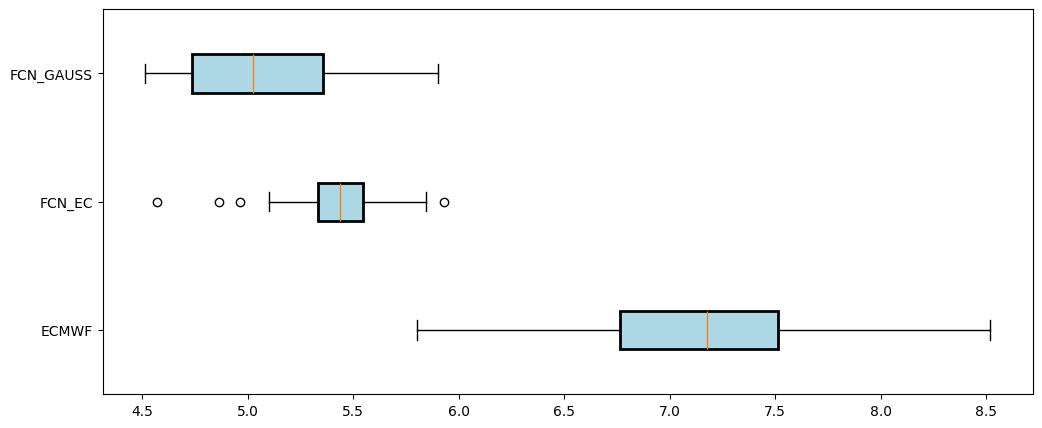

In [22]:

fig = plt.figure(figsize=(12,5))
#boxprops = dict(color='black', linewidth=1)
#boxprops=dict(color='lightblue',linewidth=0, edgecolor='blue')
colors = [ 'lightblue']

box_properties = dict(facecolor='lightblue', edgecolor='black', linewidth=2)
plt.boxplot([lt_gain_ec_t2m_5k,  lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k], labels=['ECMWF', 'FCN_EC', 'FCN_GAUSS'],vert=False,boxprops=box_properties,showfliers=True,patch_artist=True)
#colors = [ 'lightblue','lightgreen','orange']
#data_groups = [lt_gain_ec_t2m_5k,  lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k]
#boxprops = dict(color='blue', linewidth=2)

#plt.boxplot([lt_gain_ec_t2m_5k,  lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k], labels=['ECMWF', 'FCN_EC', 'FCN_GAUSS'],vert=False,boxprops=box_properties,showfliers=True,patch_artist=True)
#ax.xlabel('Lead Time (days)')
#labels=['ECMWF', 'FCN_EC', 'FCN_GAUSS']

#plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/t850_small_lg_boxplot', bbox_inches='tight',dpi=100)

In [ ]:
outlier_properties_list = [
    dict(marker='o', markerfacecolor='grey', markersize=8, markeredgecolor='black'),
    dict(marker='^', markerfacecolor='grey', markersize=8, markeredgecolor='black'),
    dict(marker='s', markerfacecolor='grey', markersize=8, markeredgecolor='black')
]

In [40]:
#calculate the median of lead time to get the lead time gain

lt_median_ec = np.median(lt_gain_ec_t2m_5k)
lt_median_fcnv1_ec = np.median(lt_gain_fcnv1_ec_t2m_5k)
lt_median_fcnv1_era = np.median(lt_gain_fcnv1_era_t2m_5k)
lt_gain_fcnv1_ec = lt_median_ec - lt_median_fcnv1_ec
lt_gain_fcnv1_era = lt_median_ec - lt_median_fcnv1_era


lt_gain_fcnv1_ec = "{:.2f}".format(lt_gain_fcnv1_ec)
lt_gain_fcnv1_era = "{:.2f}".format(lt_gain_fcnv1_era)

In [ ]:
lt_fcnv1_era = [lt_fcnv1_era_median,lt_fcnv1_era_best,lt_fcnv1_era_worst]
lt_fcnv1_ec = [lt_fcnv1_ec_median,lt_fcnv1_ec_best,lt_fcnv1_ec_worst]
lt_ec = [lt_ec_median,lt_ec_best,lt_ec_worst]

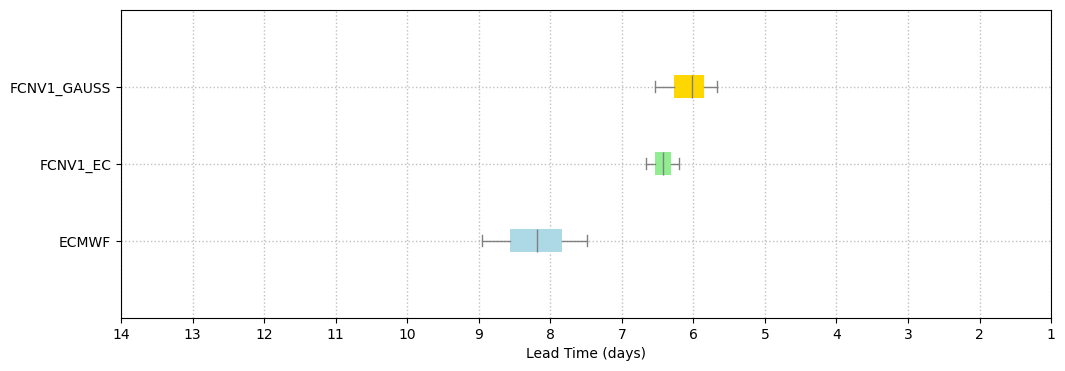

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(12, 4))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold']
box_positions = [1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV1_EC', 'FCNV1_GAUSS']  # Make sure the length matches the number of boxes

# Use enumerate to iterate over both the index and the color
for i, (data, color, position) in enumerate(zip([lt_ec, lt_fcnv1_ec, lt_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='grey'),flierprops=outlier_properties)

# Set the y-axis label
ax.set_xlabel('Lead Time (days)')
tick_labels = [str(i) for i in range(14, 0, -1)]
plt.gca().set_xticks(range(1, len(tick_labels) + 1))
plt.gca().set_xticklabels(tick_labels)

plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
#bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
#ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
plt.savefig('/home/kit/imk-tro/gj5173/not_finalized_yet_plots/leadtime_gain_t2m_5k_withouttext.png', bbox_inches='tight',dpi=100)
plt.show()

In [27]:
%store -r lt_gain_ec_t2m_5kzz
%store -r lt_gain_fcnv1_ec_t2m_5k
%store -r lt_gain_fcnv1_era_t2m_5k